# Imports

In [347]:
import math
import inflection
import datetime
import pandas      as pd
import numpy       as np
import seaborn     as sns
import scipy.stats as stats

from matplotlib             import pyplot as plt
from matplotlib             import gridspec
from tabulate               import tabulate
from IPython.display        import Image
from IPython.core.display   import HTML
from sklearn.preprocessing  import RobustScaler, MinMaxScaler

## Helper Functions

In [313]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
def get_first_order_statistics(df):
    # Central Tendency Metrics
    mean = pd.DataFrame(df.apply(np.mean)).T
    median = pd.DataFrame(df.apply(np.median)).T

    # Dispersion Metrics
    min_ = pd.DataFrame(df.apply(min)).T
    max_ = pd.DataFrame(df.apply(max)).T
    range_ = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    std = pd.DataFrame(df.apply(np.std)).T
    skew = pd.DataFrame(df.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    # Metrics Concatenation
    m = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

def cramer_v(x, y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr= k - ((k-1)**2)/(n-1)
    rcorr= r - ((r-1)**2)/(n-1)

    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

In [314]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Loading Data

In [14]:
df_sales_raw = pd.read_csv("./data/train.csv", low_memory=False)
df_store_raw = pd.read_csv("./data/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [15]:
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# <span style="color: orange;">1.0.</span> Transformações iniciais dos Dados

In [16]:
df1 = df_raw.copy()

## <span style="color: orange;">1.1.</span> Renomear as Colunas

In [17]:
# Renomear as colunas para o estilo sanke_case
df1.columns = [inflection.underscore(col) for col in df1.columns]

In [18]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## <span style="color: orange;">1.2.</span> Data Dimension

In [19]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number of Cols {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of Cols 18


## <span style="color: orange;">1.3.</span> Tipo dos Dados

In [20]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## <span style="color: orange;">1.4.</span> Verifica NA

In [21]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## <span style="color: orange;">1.5.</span> Preencher os NA

In [22]:
# competition_distance -  suposição que quando competition_distance é NA significa que a loja não tem um competido próximo
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if pd.isna(x) else x)
          
# competition_open_since_month  
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week 
df1['promo2_since_week'] = df1[['promo2_since_week', 'date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)            

# promo2_since_year   
df1['promo2_since_year'] = df1[['promo2_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)

month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                       0, axis =1) 


## <span style="color: orange;">1.6.</span> Alterar Tipos

Ao criar novas colunas é importante checar de novo o tipo das colunas, pois o resultado das operações pode ter alterado o tipo original.

In [23]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# <span style="color: orange;">2.0.</span> Estatística Descritiva

In [24]:
df2 = df1.copy()

In [25]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])
cat_attributes = df2.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## <span style="color: orange;">2.1.</span> Numerical Attributes

In [27]:
get_first_order_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


- Rossmann was founded in 1972. Values of Competition_open_since_year lower than 1972 indicate the years when closest competitors, from other pharmacy chains, were opened.

- The competition_distance variable has high positive values of skew and kurtosis, indicating that the distribution is skewed right and has a large tail.

- There is a vast difference in the range in some features. Higher ranging numbers have superiority of some sort. So these more significant number starts playing a more decisive role while training some models. It's needed to apply some sort of scaling over the features.

## <span style="color: orange;">2.2.</span> Categorical Attributes

In [28]:
 # How many levels there is  in each categorical attribute
cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

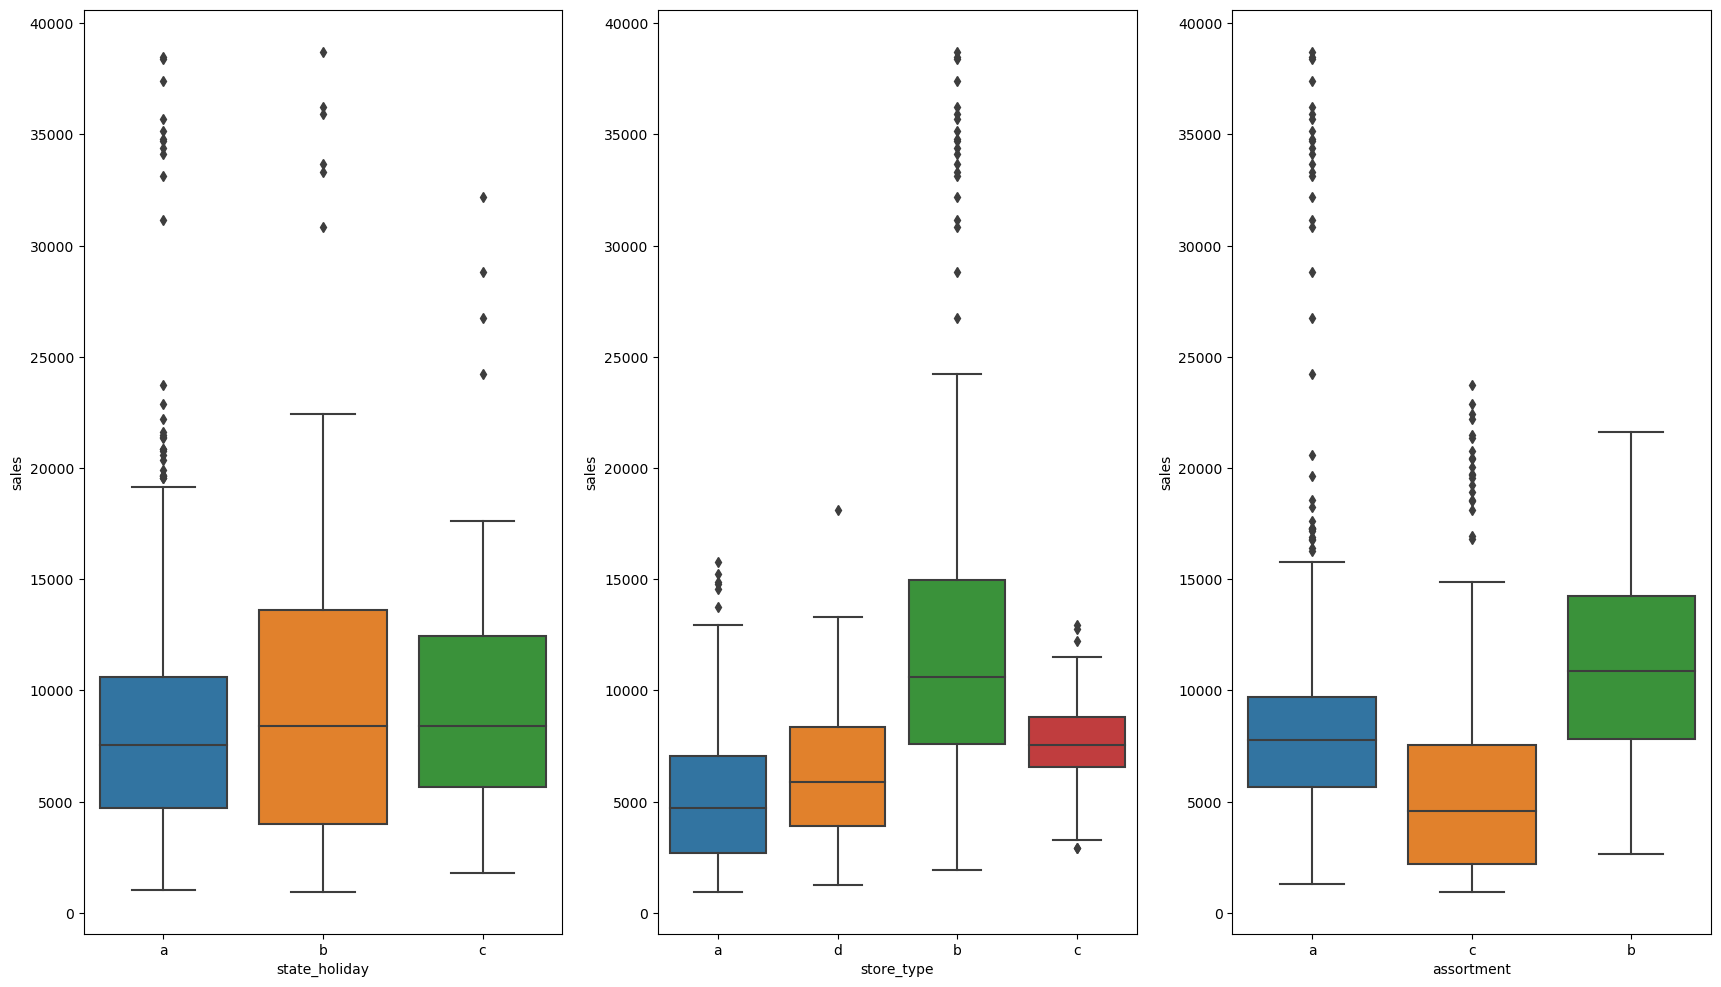

In [29]:
# Filtrar apenas registros em dias comerciais com vendas superiores a 0
aux1 =df1[(df1.state_holiday !='0' ) & (df1.sales > 0)]

# Boxplots são úteis para vizualizar medidas de dispersão e tendencia central em um gráfico apenas
# Linha do meio é a mediana
# box limitado pelos 25th quartil and 75th quartil
# Outliers fora do boxplot

fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row
ax2 = fig.add_subplot(specs[0,1])  # First row Second Column
ax3 = fig.add_subplot(specs[0,2])  # First row Third Column

sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=ax1)

sns.boxplot(x='store_type', y='sales', data=aux1, ax=ax2)

sns.boxplot(x='assortment', y='sales', data=aux1, ax=ax3)

# <span style="color: orange;">3.0.</span> Feature Engineering

## <span style="color: orange;">3.1.</span> Mind Map Hypothesis

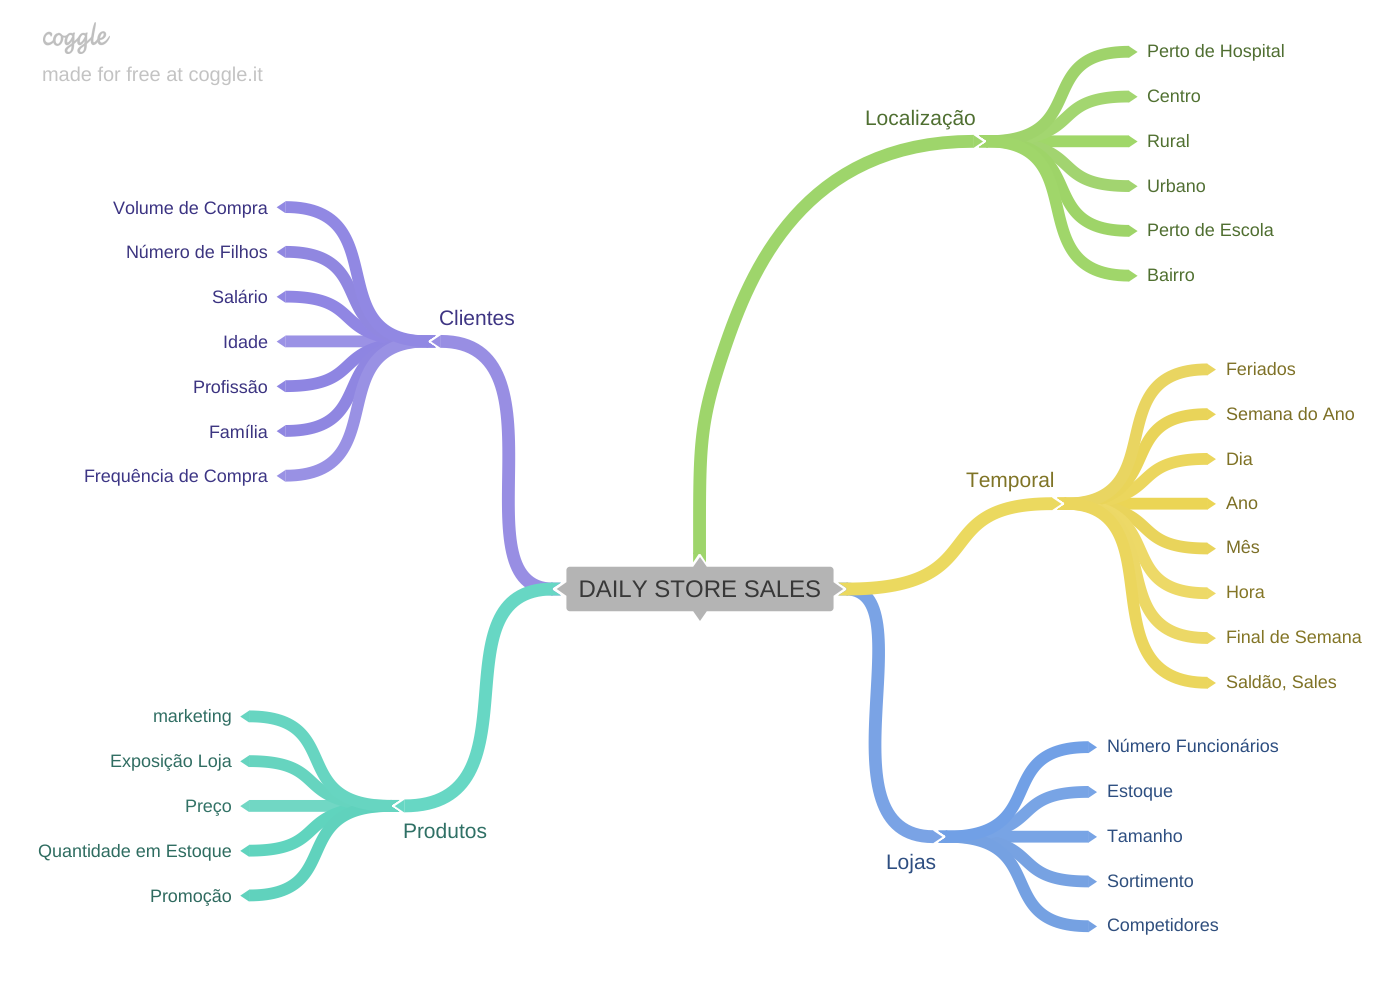

In [30]:
Image("./img/mind_map_hypothesis.png")

## <span style="color: orange;">3.2.</span> Creation of Hypotheses

### <span style="color: orange;">3.2.1 </span> Store Hypotheses

**1.** Stores with a staff of employees should sell more.

**2.** Stores with a larger inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors that have been around for a longer time should sell more.

### <span style="color: orange;">3.2.2 </span> Product Hypotheses

**1.** Stores that invest more in marketing should sell more

**2.** Stores that display more products in the window should sell more

**3.** Stores with lower product prices should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more

**5.** Stores with longer product promotions should sell more.

**6.** Stores with more days of promotions should sell more

**7.** Stores with more consecutive promotions should sell more

### <span style="color: orange;">3.2.3 </span> Time Hypotheses

**1.** Stores open during the Christmas holidays should sell more.

**2.** Stores should sell more throughout the year.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## <span style="color: orange;">3.3 </span> Final List of Hypotheses

**H1.** On average, stores with a larger assortment should sell more.

**H2.** Stores with closer competitors should sell less.

**H3.** Stores with competitors that have been around for longer should sell more.

**H4.** Stores with more consecutive promotions should sell more than stores with regular promotion

**H5.** Stores open during the Christmas holidays should sell more.

**H6.** Stores should sell more over the years.

**H7.** Stores should sell more in the second half of the year

**H8.** Stores should sell less after the 10th of each month.

**H9.** Stores should sell more on average on weekends.

**H10.** Stores should sell less during school holidays.

## <span style="color: orange;">3.4 </span> Feature Engineering

In [68]:
df3 = df2.copy()

In [70]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

# competition since
df3['competition_since'] = df3.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df3['competition_time_month'] = ((df3['date'] - df3['competition_since'])/np.timedelta64(1,'M'))

# promo since
df3['promo_since'] = pd.to_datetime(df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str) + '-1', 
                                    format='%Y-%W-%w') - pd.Timedelta(days=7)

df3['promo_time_week'] = ((df3['date'] - df3['promo_since'])/np.timedelta64(1,'W'))

# assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state_holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# <span style="color: orange;">4.0.</span> Feature Filtering

## <span style="color: orange;">4.1.</span> Rows Filtering

In [71]:
df4 = df3.copy()

In [72]:
# There is no sales on closed stores
df4[(df4['open'] == 0) & (df4['sales'] > 0)] 

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,competition_since,competition_time_month,year,month,day,week_of_year,year_week,promo_since,promo_time_week


In [73]:
df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]

## <span style="color: orange;">4.2.</span> Columns Filtering

In [74]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo',
       'competition_since', 'competition_time_month', 'year', 'month', 'day',
       'week_of_year', 'year_week', 'promo_since', 'promo_time_week'],
      dtype='object')

In [75]:
# Para realizar previsão de vendas teria que ter a quantidade de customers no futuro
# 'open' foi removida pois não contem informação a ser aprendida
# 'promo_interval', 'month_map' foram removidas, pois a partir das duas foi criada a variável is_promo (numérica)
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df4 = df4.drop(cols_drop, axis=1)

In [76]:
df4.to_csv('dataframes/df4.csv', index=False)

# <span style="color: orange;">5.0.</span> Split Into Training and Test Set

In [350]:
df5 = pd.read_csv('./dataframes/df4.csv', parse_dates=['date', 'competition_since', 'promo_since'])

Since we are working with a temporal problem, we cannot randomly select which rows will belong to the training set and which rows will belong to the testing set. Since the goal is to forecast sales for the next 6 weeks, the last 6 weeks of sales will be used as testing and the previous 6 weeks will be used as training.

In [317]:
df5[['store', 'date']].groupby('store').max()['date'].max() - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [352]:
data_limit = df5[['store', 'date']].groupby('store').max()['date'].max() - datetime.timedelta(days=6*7)

# df_sample = df6.sample(n=400000)

# training dataset
X_train = df5[df5['date'] < data_limit]
y_train = X_train['sales']

# test dataset
X_test = df5[df5['date'] >= data_limit]
y_test = X_test['sales']

print('Training Min date: {}'.format(X_train['date'].min()))
print('Training Max date: {}'.format(X_train['date'].max()))

print('\nTest Min date: {}'.format(X_test['date'].min()))
print('Test Max date: {}'.format(X_test['date'].max()))

X_train.to_csv('dataframes/X_train.csv', index=False)
y_train.to_csv('dataframes/y_train.csv', index=False)
X_test.to_csv('dataframes/X_test.csv', index=False)
y_test.to_csv('dataframes/y_test.csv', index=False)

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


# <span style="color: orange;">6.0.</span> Exploratory Data Analysis

## <span style="color: orange;">6.1.</span> Univariate Analysis

### <span style="color: orange;">6.1.1 </span> Response Variable

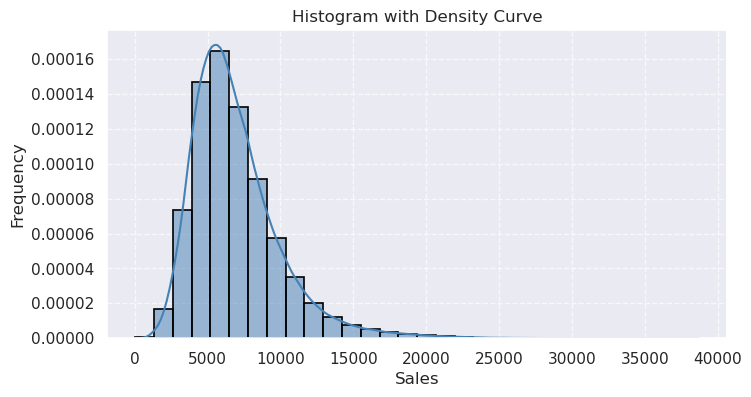

In [319]:
# Criando o histograma e a curva de densidade
plt.figure(figsize=(8, 4))
sns.histplot(X_train['sales'], bins=30, kde=True, stat="density", color='steelblue', edgecolor='black', linewidth=1.2)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram with Density Curve')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### <span style="color: orange;">6.1.2 </span> Numerical Variables

/tmp/ipykernel_50303/2232118446.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(bins=25, ax=ax);


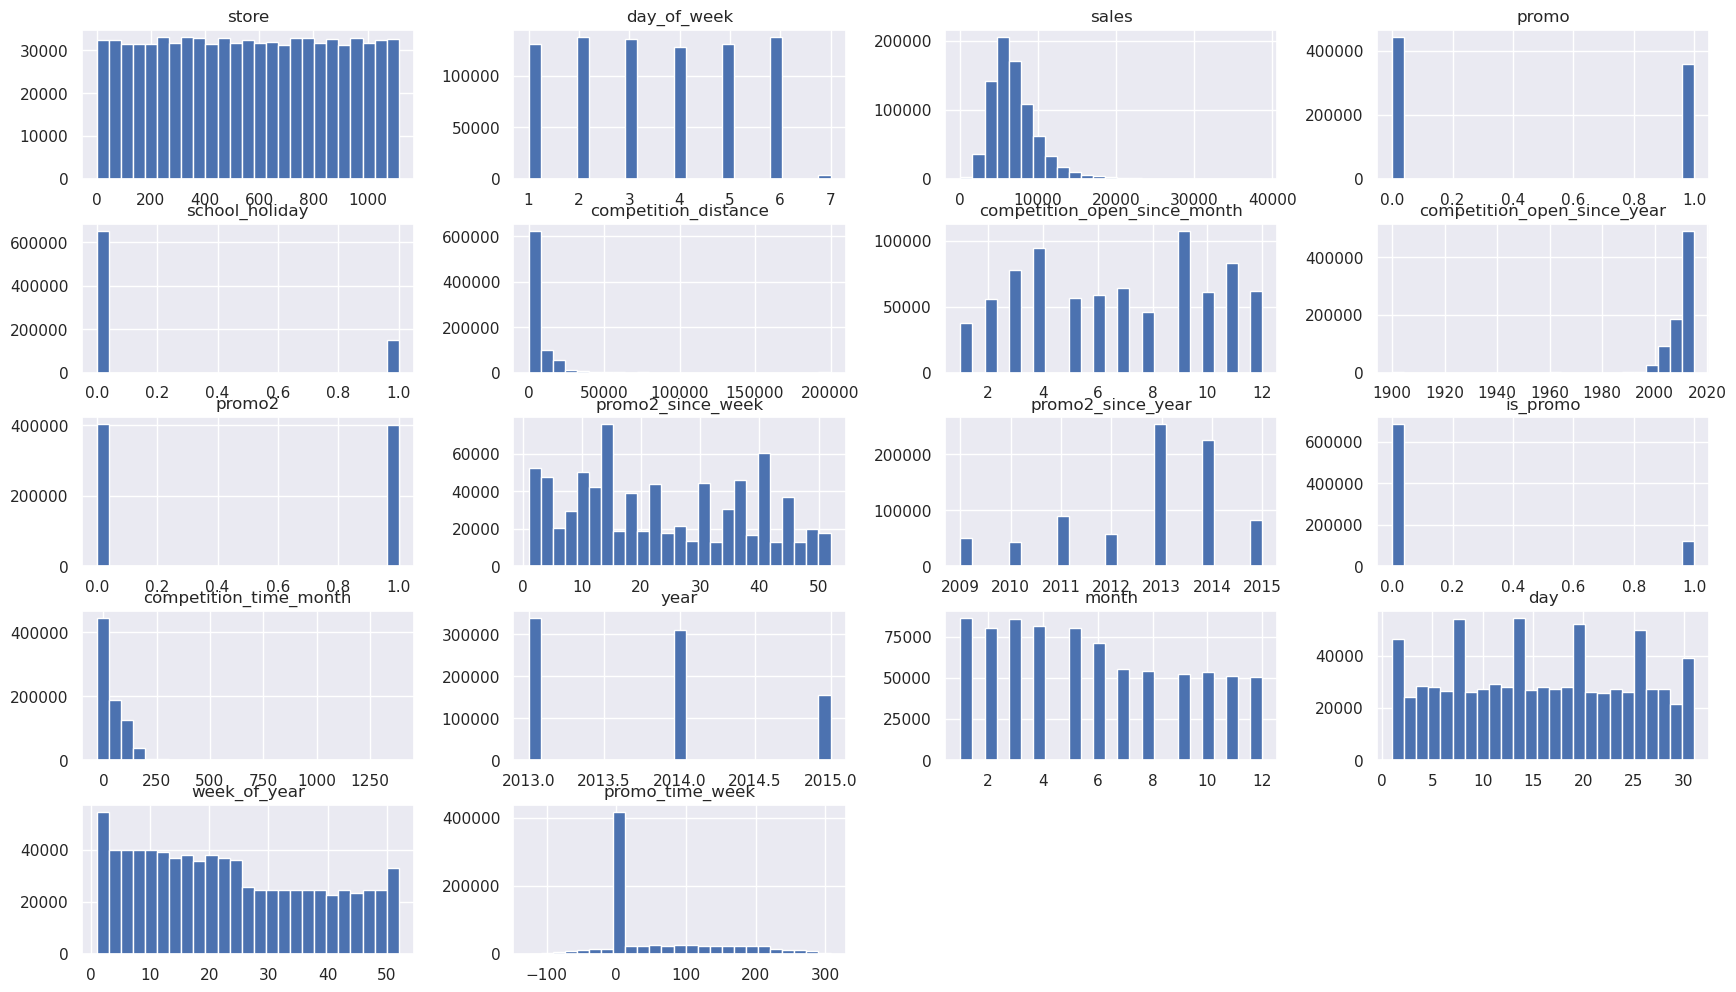

In [320]:
num_attributes = X_train.select_dtypes(include=['int64', 'float64']);

fig = plt.figure(figsize=(21,12));
ax = fig.add_subplot();

num_attributes.hist(bins=25, ax=ax);

### <span style="color: orange;">6.1.2 </span> Categorical Variables

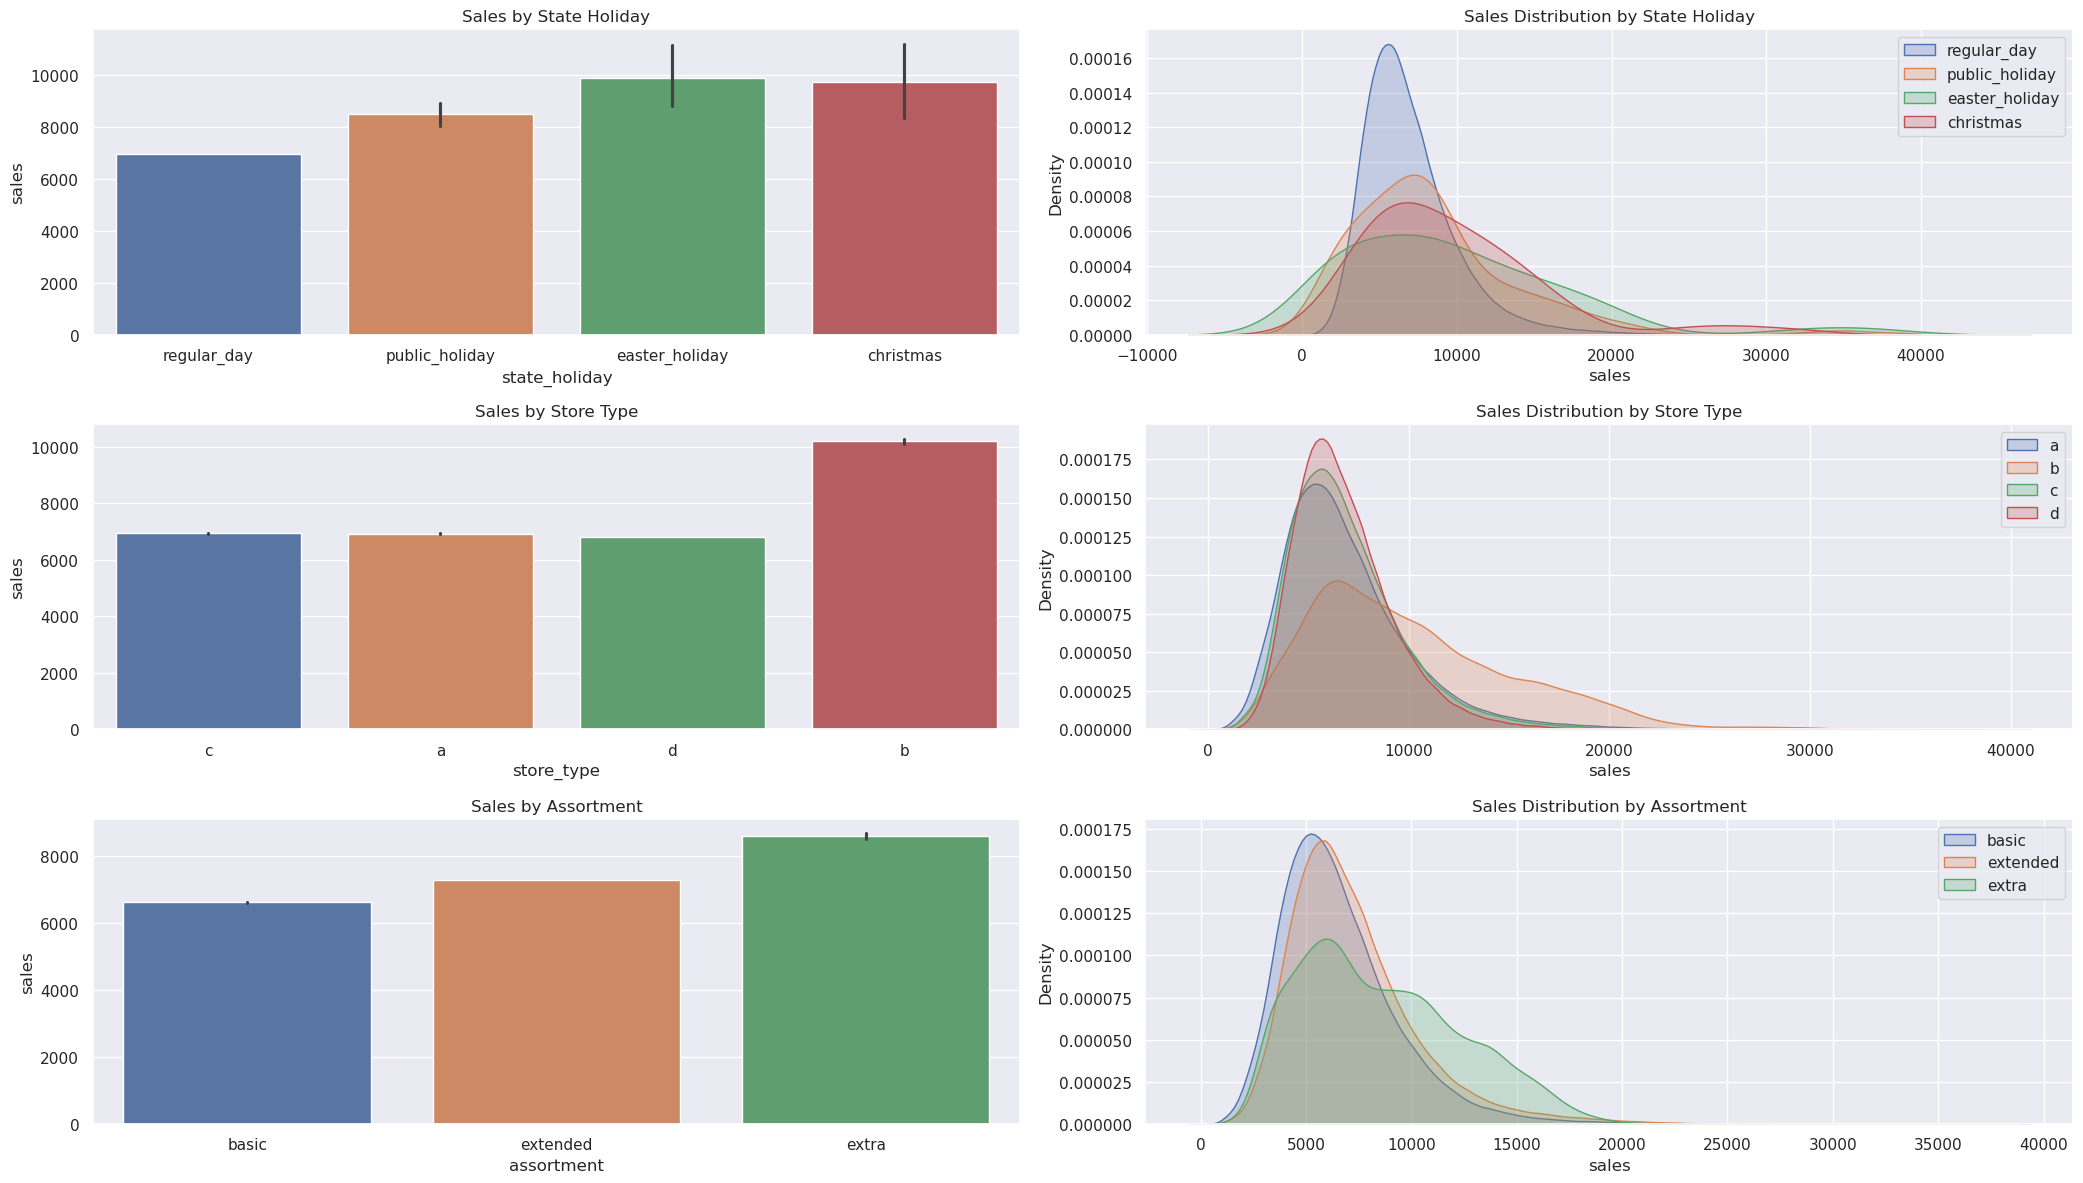

In [324]:
fig = plt.figure(figsize=(21,12))

plt.subplot(3, 2, 1)
sns.barplot(x='state_holiday', y='sales', hue='state_holiday', data=X_train)
plt.title('Sales by State Holiday')

# plots de densidade de distribuição
plt.subplot(3, 2, 2)
sns.kdeplot(X_train[X_train['state_holiday'] == 'regular_day']['sales'], label='regular_day', fill= True)
sns.kdeplot(X_train[X_train['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill= True)
sns.kdeplot(X_train[X_train['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill= True)
sns.kdeplot(X_train[X_train['state_holiday'] == 'christmas']['sales'], label='christmas', fill= True)
plt.legend()
plt.title('Sales Distribution by State Holiday')

plt.subplot(3, 2, 3)
sns.barplot(x='store_type', y='sales', hue='store_type', data=X_train)
plt.title('Sales by Store Type')

plt.subplot(3, 2, 4)
# plots de densidade de distribuição
sns.kdeplot(X_train[X_train['store_type'] == 'a']['sales'], label='a', fill= True)
sns.kdeplot(X_train[X_train['store_type'] == 'b']['sales'], label='b', fill= True)
sns.kdeplot(X_train[X_train['store_type'] == 'c']['sales'], label='c', fill= True)
sns.kdeplot(X_train[X_train['store_type'] == 'd']['sales'], label='d', fill= True)
plt.legend()
plt.title('Sales Distribution by Store Type')

plt.subplot(3, 2, 5)
sns.barplot(x='assortment', y='sales', hue='assortment', data=X_train)
plt.title('Sales by Assortment')

# plots de densidade de distribuição
plt.subplot(3, 2, 6)
sns.kdeplot(X_train[X_train['assortment'] == 'basic']['sales'], label='basic', fill= True)
sns.kdeplot(X_train[X_train['assortment'] == 'extended']['sales'], label='extended', fill= True)
sns.kdeplot(X_train[X_train['assortment'] == 'extra']['sales'], label='extra', fill= True)
plt.legend()
plt.title('Sales Distribution by Assortment')

plt.tight_layout()
plt.show()

## <span style="color: orange;">6.2.</span> Bivariate Analysis

### **H1.** On average, stores with a larger assortment should sell more.

**True** stores with a larger assortment sell more on average

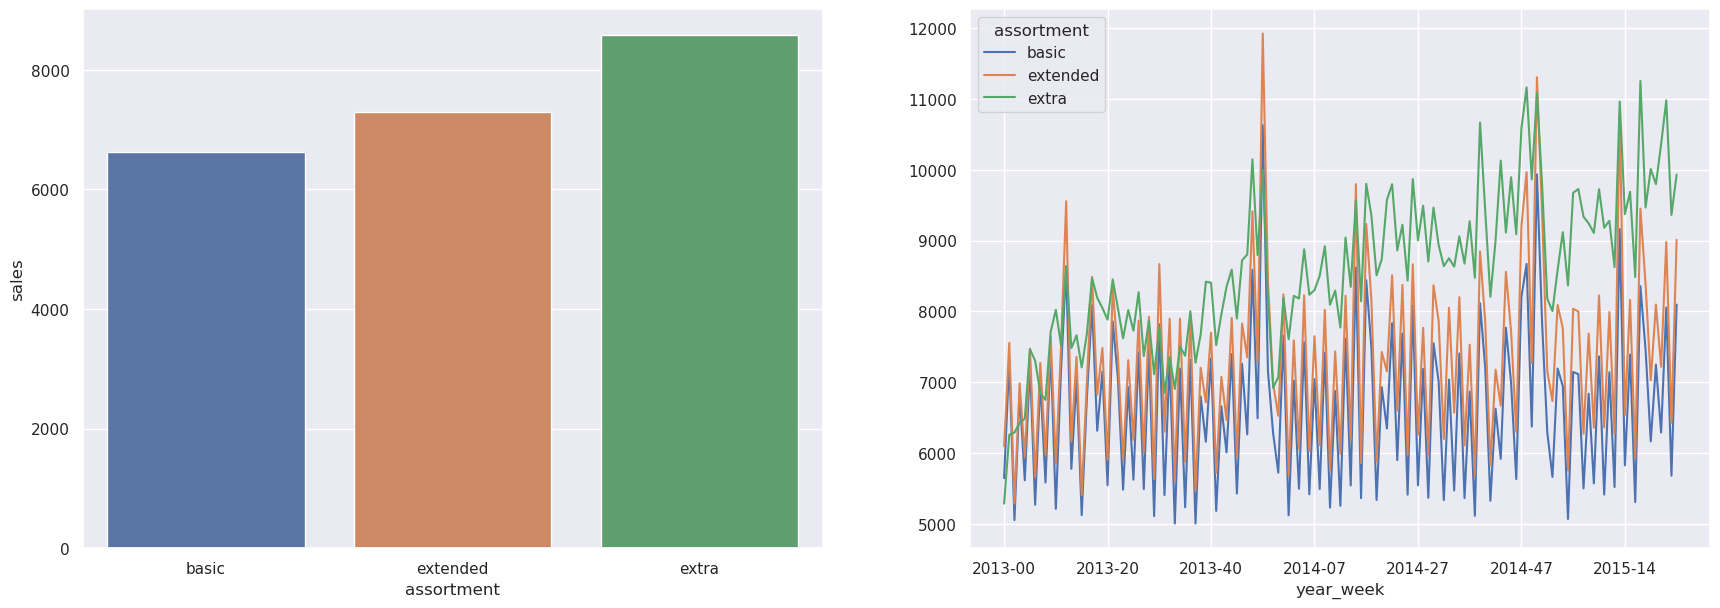

In [325]:
fig = plt.figure(figsize=(21,7))
specs = gridspec.GridSpec(ncols=2, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  
ax2 = fig.add_subplot(specs[0,1])   


aux1 = X_train[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, hue='assortment', ax=ax1); 

aux2 = X_train[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax2)

fig.savefig('./img/H1.png')

#### Hypothesis Testing

- **H0 (Null Hypothesis)**: The mean sales for stores with a larger assortment are less than or equal the mean sales for stores with a smaller assortment.

- **H1 (Alternative Hypothesis)**: The mean sales for stores with a larger assortment are significantly greater than the mean sales for stores with a smaller assortment.

In [326]:
# Grouping data
larger_assortment = X_train[X_train['assortment'].isin(['extended', 'extra'])]['sales']
smaller_assortment = X_train[X_train['assortment'] == 'basic']['sales']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(larger_assortment, smaller_assortment, alternative='greater')

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 100.20756094259846
P-value: 0.0


- **P-value < 0.05**: There is statistical evidence to reject the null hypothesis. This means that there is enough evidence to conclude that stores with a larger assortment sell more on average compared to stores with a smaller assortment.

### **H2.** Stores with closer competitors should sell less.

**False**, there is virtually no correlation between sales and closer competitors

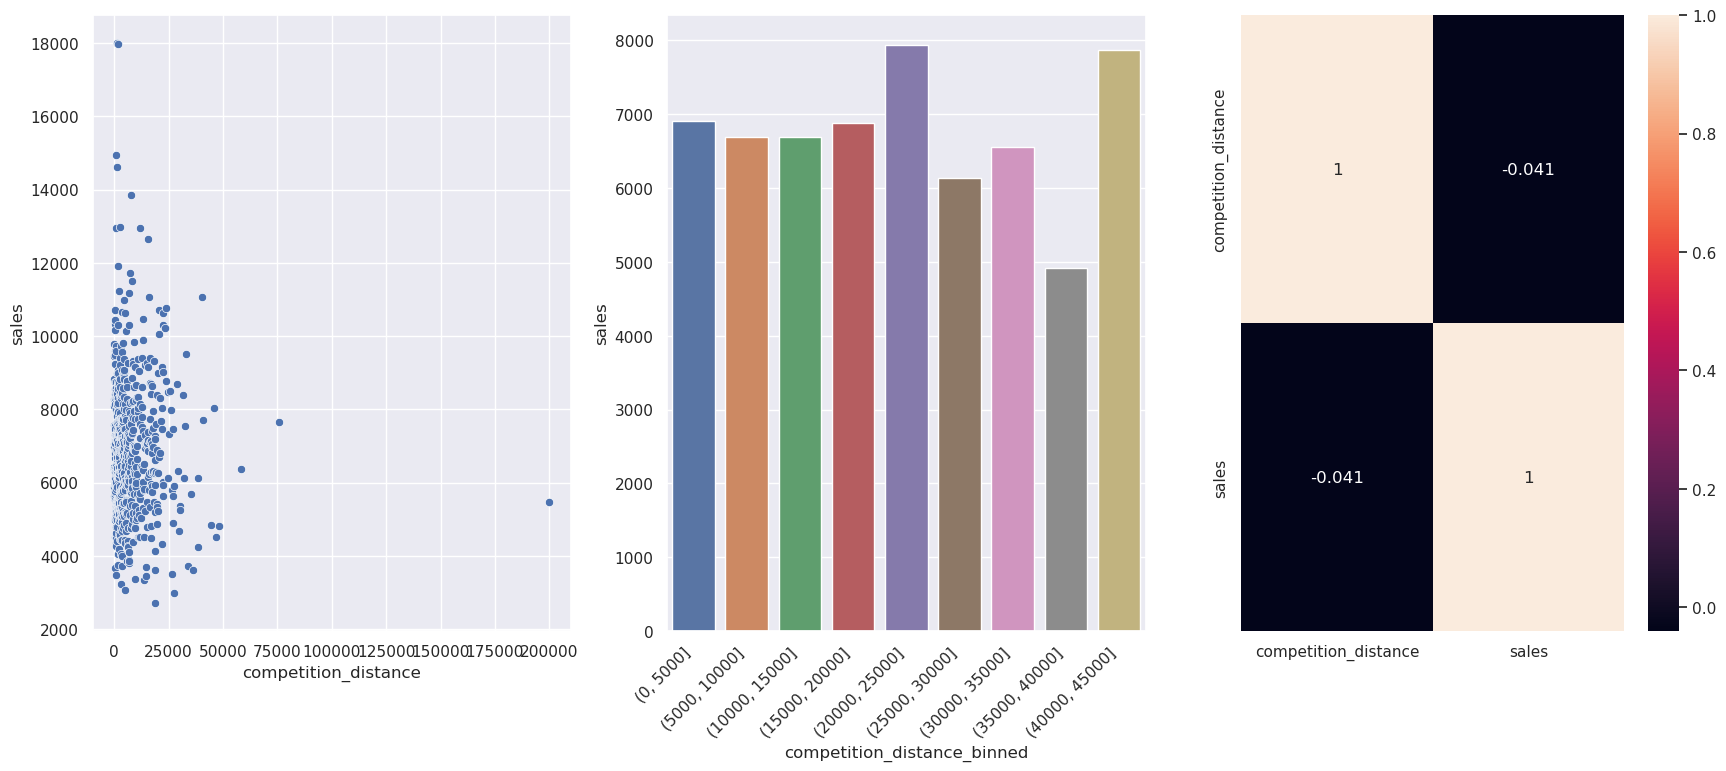

In [327]:
fig = plt.figure(figsize=(21,8))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row 
ax2 = fig.add_subplot(specs[0,1])  # Second row 
ax3 = fig.add_subplot(specs[0,2])  # Third row 


aux1 = X_train[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

sns.scatterplot(data=aux1, x='competition_distance', y='sales', ax=ax1)

bins = list(np.arange(0, 50000, 5000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned', observed=False).mean().reset_index()


sns.barplot(x='competition_distance_binned', y='sales', hue='competition_distance_binned', data=aux2, ax=ax2); 
# ax2.set_xticklabels(labels=aux2['competition_distance_binned'], rotation=45, ha='right')

# Set tick positions and labels
ax2.set_xticks(range(len(aux2['competition_distance_binned'])))
ax2.set_xticklabels(aux2['competition_distance_binned'], rotation=45, ha='right')

ax2.legend_.remove()

sns.heatmap(X_train[['competition_distance', 'sales']].corr(method='spearman'), annot=True, ax=ax3);

#### Hypothesis Testing

- **Null Hypothesis (H0)**: There is no significant correlation between distance from competition and sales. (i.e., distance from competition does not affect sales)

- **Alternative Hypothesis (H1)**: There is a significant negative correlation between distance from competition and sales. (i.e., stores with closer competitors have lower sales)

In [328]:
correlation, p_value = stats.spearmanr(X_train['sales'], X_train['competition_distance'])

print(f'Correlation coefficient: {correlation}')
print(f'P-value: {p_value}')

Correlation coefficient: -0.04063656295725005
P-value: 1.522969720582561e-290


- **P-value < 0.05**: There is statistical evidence to reject the null hypothesis. However, the very weak negative correlation coefficient suggests that the relationship between sales and competition_distance is practically insignificant. Thus, while the correlation is statistically significant, it does not have a strong practical impact.

### **H3.** Stores with competitors that have been around for longer should sell more.

**False** there is virtually no correlation between sales and months in competition

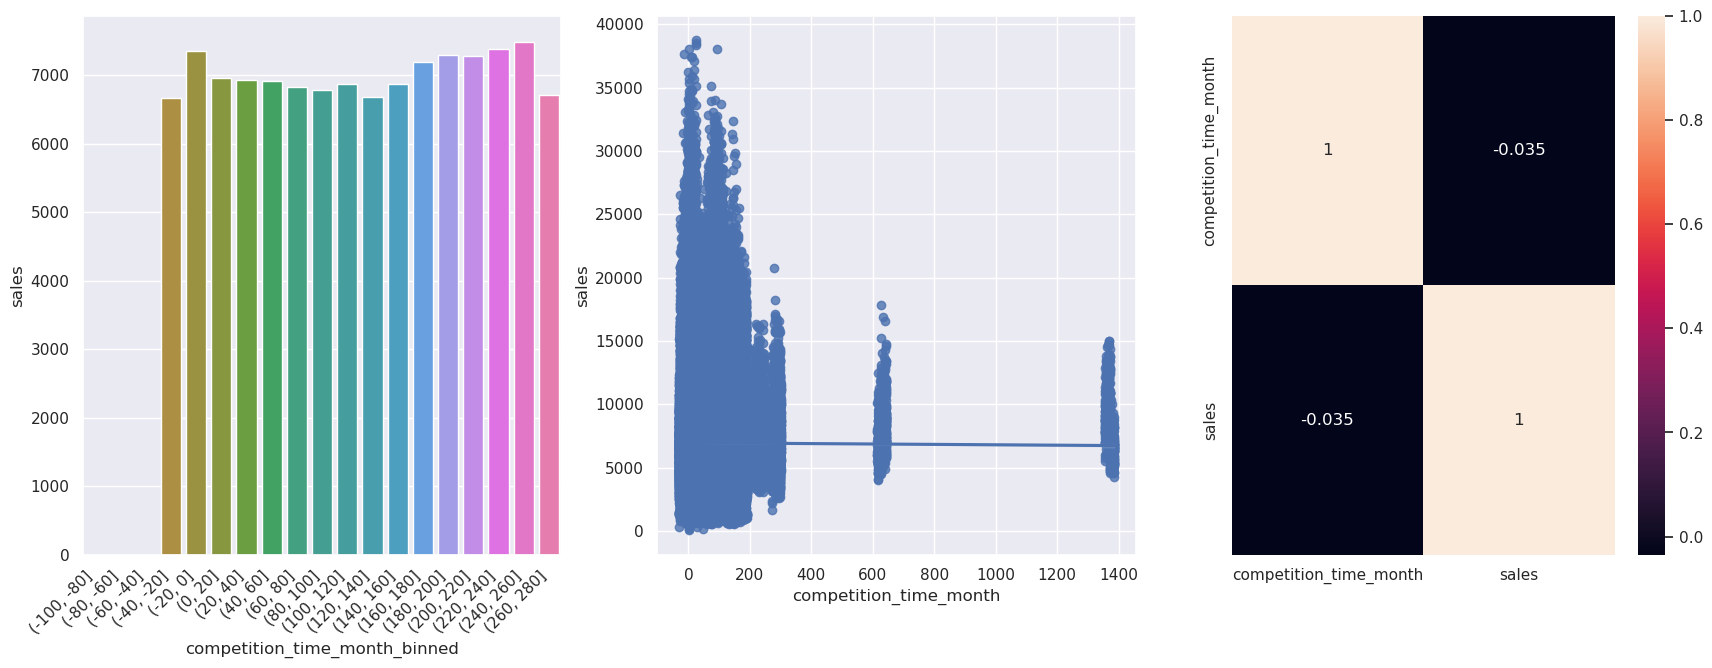

In [329]:
fig = plt.figure(figsize=(21,7))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row 
ax2 = fig.add_subplot(specs[0,1])  # Second row 
ax3 = fig.add_subplot(specs[0,2])  # Third row 

aux1 = X_train.copy()
bins = list(np.arange(-100, 300, 20))
aux1['competition_time_month_binned'] = pd.cut(X_train['competition_time_month'], bins=bins)
aux2 = aux1[['competition_time_month_binned', 'sales']].groupby('competition_time_month_binned', observed=False).mean().reset_index()

sns.barplot( x='competition_time_month_binned', y='sales', hue='competition_time_month_binned', data=aux2, ax=ax1 );
ax1.legend_.remove()
ax1.set_xticks(range(len(aux2['competition_time_month_binned'])), 
               labels=aux2['competition_time_month_binned'], rotation=45, ha='right')

sns.regplot(x='competition_time_month', y='sales', data=X_train, ax= ax2)

sns.heatmap(X_train[['competition_time_month', 'sales']].corr(method='spearman'), annot=True, ax=ax3);

#### Hypothesis Testing

- **Null Hypothesis (H0)**: There is no significant correlation between months in competition and sales. 

- **Alternative Hypothesis (H1)**: There is a significant positive correlation between between months in competition sales. 

In [330]:
correlation, p_value = stats.spearmanr(X_train['sales'], X_train['competition_time_month'])

print(f'Correlation coefficient: {correlation}')
print(f'P-value: {p_value}')

Correlation coefficient: -0.035114992976660785
P-value: 1.900514080828543e-217


- **P-value < 0.05**: There is statistical evidence to reject the null hypothesis. However, the very weak negative correlation coefficient suggests that the relationship between sales and competition_time_month is practically insignificant. Thus, while the correlation is statistically significant, it does not have a strong practical impact.

### **H4.** Stores with more consecutive promotions should sell more than stores with regular promotion

**Falso** Lojas com mais promocoes consecutivas vendem menos

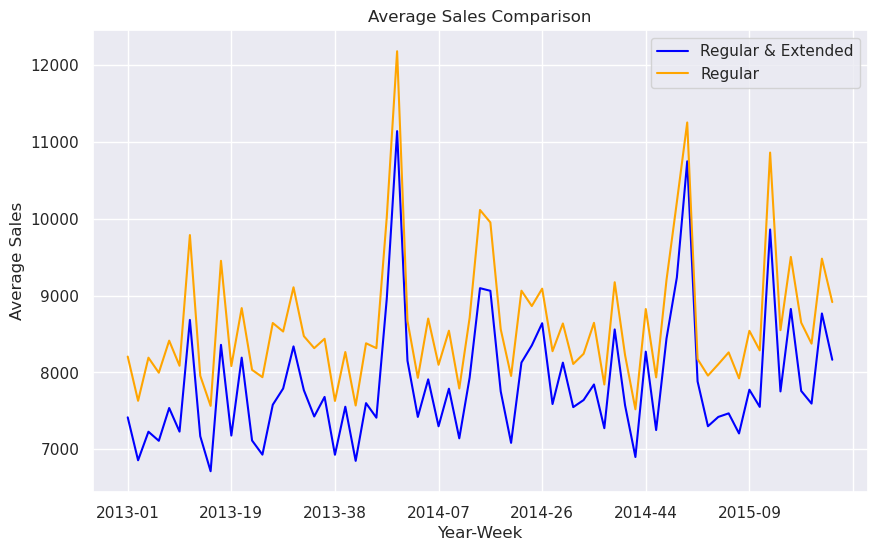

In [331]:
aux1 = X_train[(X_train['promo'] == 1) & (X_train['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2 = X_train[(X_train['promo'] == 1) & (X_train['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data
aux1.plot(x='year_week', y='sales', ax=ax, label='Regular & Extended', color='blue')
aux2.plot(x='year_week', y='sales', ax=ax, label='Regular', color='orange')

# Adding legend and titles
ax.legend()
ax.set_title('Average Sales Comparison')
ax.set_xlabel('Year-Week')
ax.set_ylabel('Average Sales')

# Save the figure
fig.savefig('./img/H04.png')

# Show plot (optional)
plt.show()

#### Hypothesis Testing

- **H0 (Null Hypothesis)**: The mean sales for stores with consecutives promotions are less than or equal the mean sales for stores with regular promotions.

- **H1 (Alternative Hypothesis)**: The mean sales for stores with consecutives promotions are greater than the mean sales for stores with regular promotions.

In [332]:
# Grouping data
consecutive_promo     = X_train[(X_train['promo'] == 1) & (X_train['promo2'] == 1)]['sales']
regular_promo = X_train[(X_train['promo'] == 1) & (X_train['promo2'] == 0)]['sales']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(consecutive_promo, regular_promo, alternative='greater')

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: -74.4053339967672
P-value: 1.0


- **P-value > 0.05**: There is no statistical evidence to reject the null hypothesis. This means that there is not enough evidence to conclude that stores with consecutive promotion sell more than stores with regular promotion.

### **H5.** Stores open during the Christmas holidays should sell more.

**True** there is statistical evidence enough to conclude that sales during Christmas are greater on average than sales during other holidays.

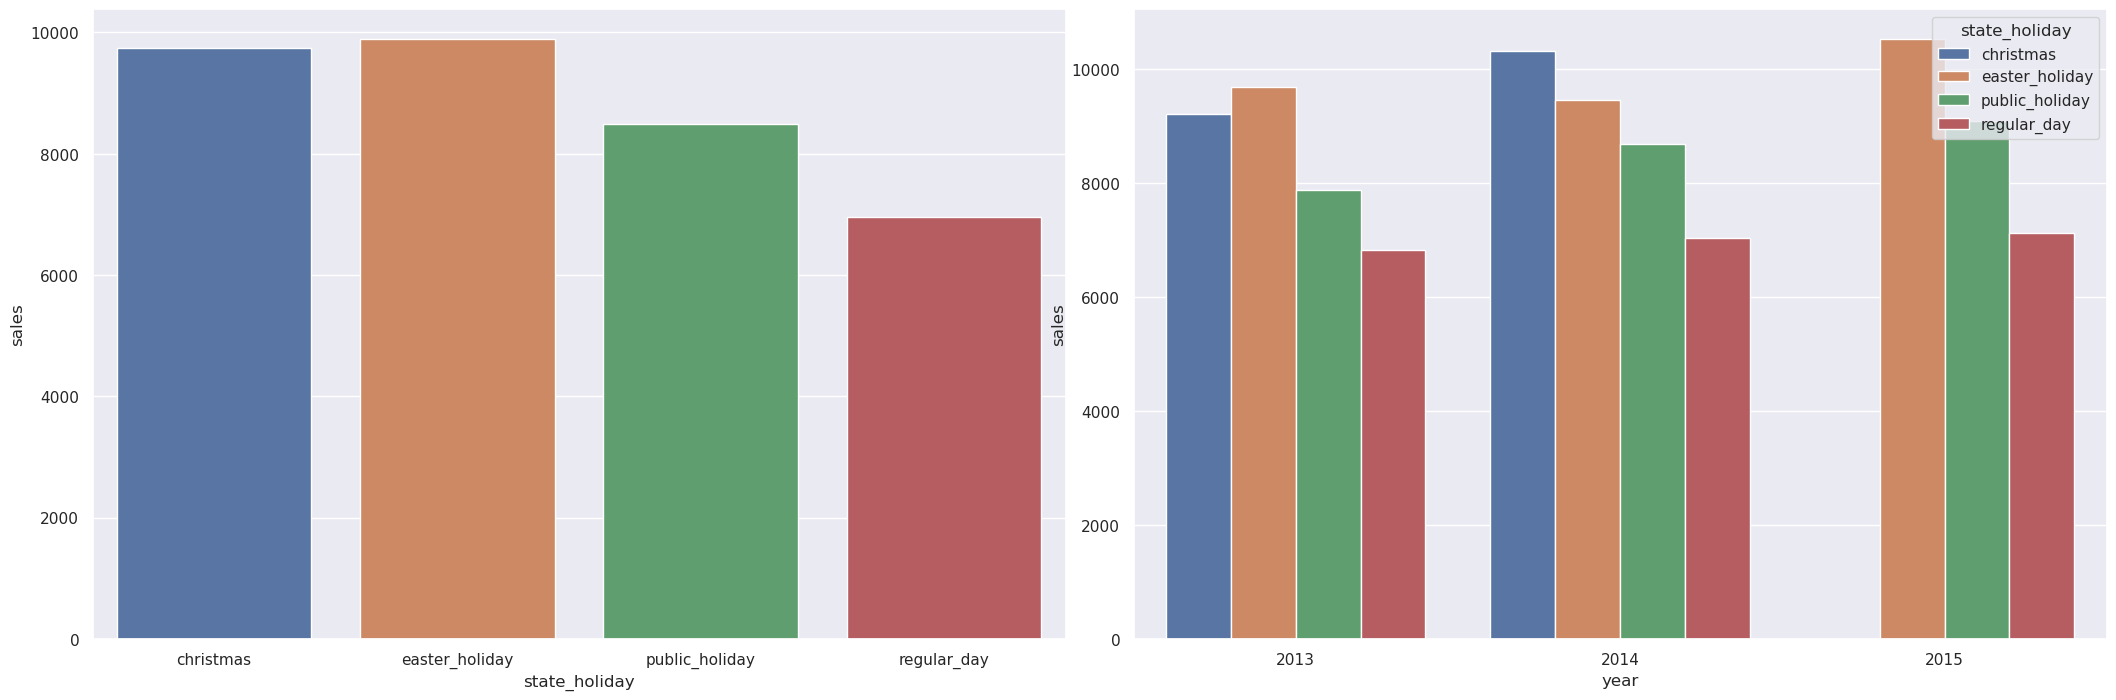

In [333]:
#define subplots
fig, ax = plt.subplots(1, 2, figsize=(21,7))
fig.tight_layout()

aux1 = X_train[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', hue='state_holiday', data=aux1, ax=ax[0])

aux2 = X_train[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2,ax=ax[1]);

#### Hypothesis Testing

- H0 (Null Hypothesis): The mean sales on Christmas days are less than or equal the mean sales on other days.

- H1 (Alternative Hypothesis):  The mean sales on Christmas days are greater than the mean sales on other days. 


In [334]:
# Filtrar vendas durante o Natal e outros dias
sales_christmas = X_train[X_train['state_holiday'] == 'christmas']['sales']
sales_others = X_train[X_train['state_holiday'] != 'christmas']['sales']

# Realizar o teste t de Student
t_stat, p_value = stats.ttest_ind(sales_christmas, sales_others, alternative='greater')

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 7.566884821852601
P-value: 1.913422474974311e-14


- **P-value < 0.05**: There is statistical evidence to reject the null hypothesis. This means that there is enough evidence to conclude that sales during Christmas are greater than sales during other days.

### **H6.** Stores should sell more over the years.

**True** there is statistical evidence enough to conclude that sales increase over the years, but the practical relevance of the correlation is very low.

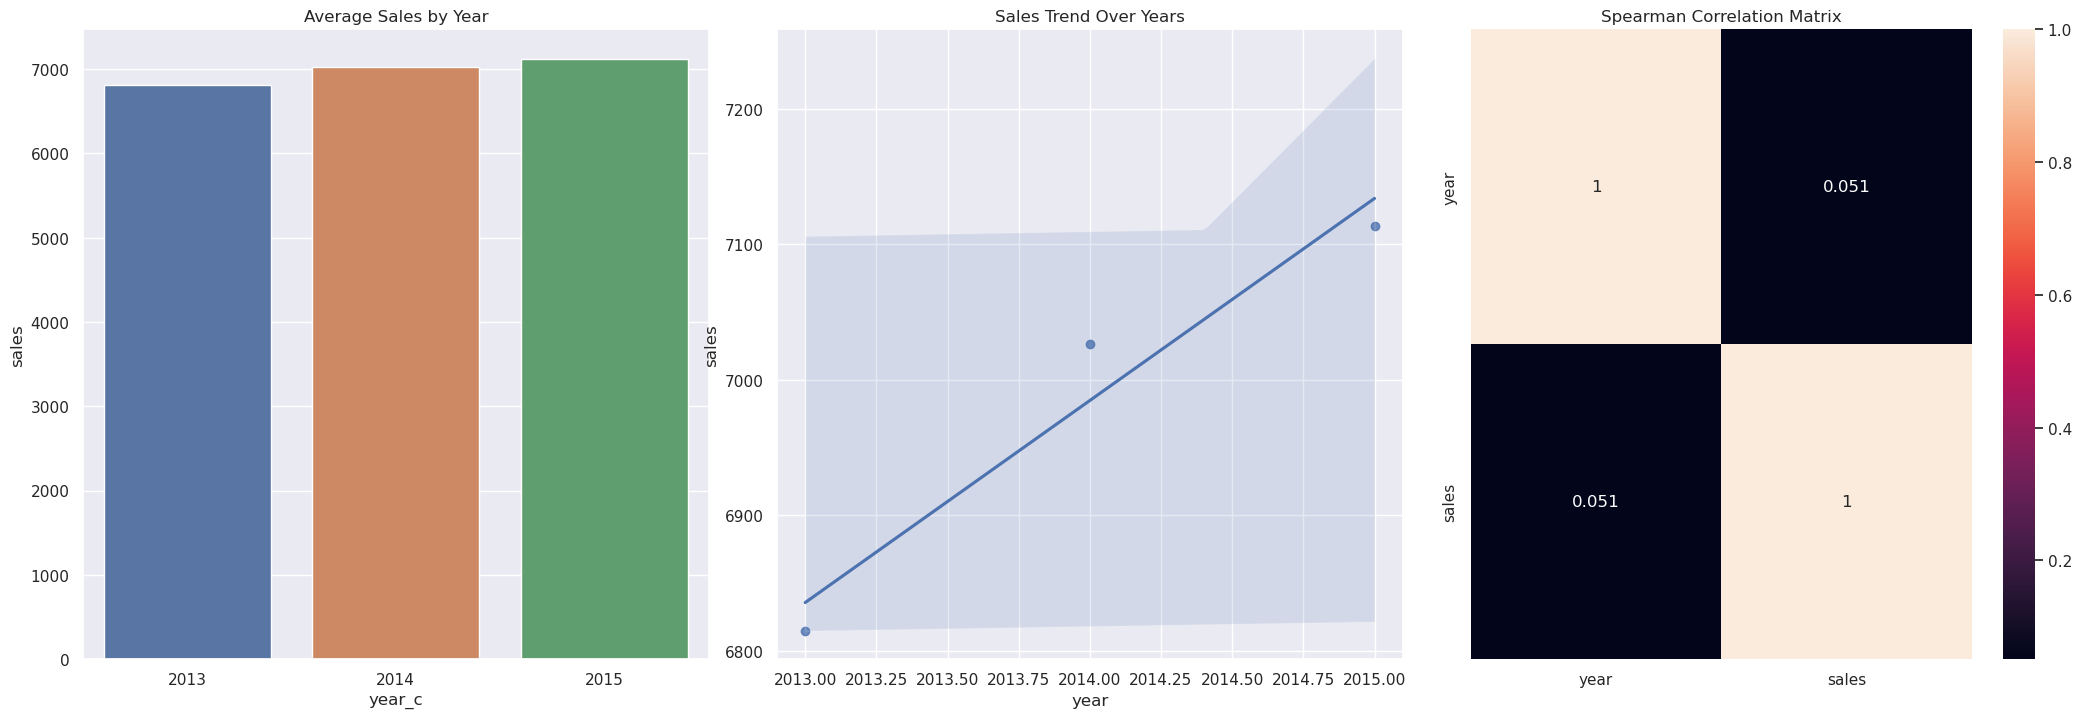

In [335]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
fig.tight_layout()

# Dados agrupados por ano
aux1 = X_train[['year', 'sales']].groupby('year').mean().reset_index()
# Convert year to categorical
aux1['year_c'] = aux1['year'].astype('category')

# Gráfico de barras com vendas médias por ano
sns.barplot(x='year_c', y='sales', data=aux1, hue='year_c', ax=ax[0]).set(title='Average Sales by Year')
ax[0].legend_.remove()

# Regressão linear entre ano e vendas
sns.regplot(x='year', y='sales', data=aux1, ax=ax[1]).set(title='Sales Trend Over Years')

# Matriz de correlação usando Spearman
sns.heatmap(X_train[['year', 'sales']].corr(method='spearman'), annot=True, ax=ax[2])
ax[2].set_title('Spearman Correlation Matrix');

#### Hypothesis Testing

- **Null Hypothesis (H0)**: There is no significant correlation between distance years and sales. 

- **Alternative Hypothesis (H1)**: There is a significant positive correlation between years and sales.

In [336]:
correlation, p_value = stats.spearmanr(X_train['sales'], X_train['year'])

print(f'Correlation coefficient: {correlation}')
print(f'P-value: {p_value}')

Correlation coefficient: 0.05095951946699543
P-value: 0.0


- **P-value < 0.05**: There is statistical evidence to reject the null hypothesis. However, the very weak positive correlation coefficient suggests that the relationship between sales and year is practically insignificant. Thus, while the correlation is statistically significant, it does not have a strong practical impact.

### **H7.** Stores should sell more in the second half of the year

**True** there is statistical evidence enough to conclude that stores should sell more in the second half of the year.

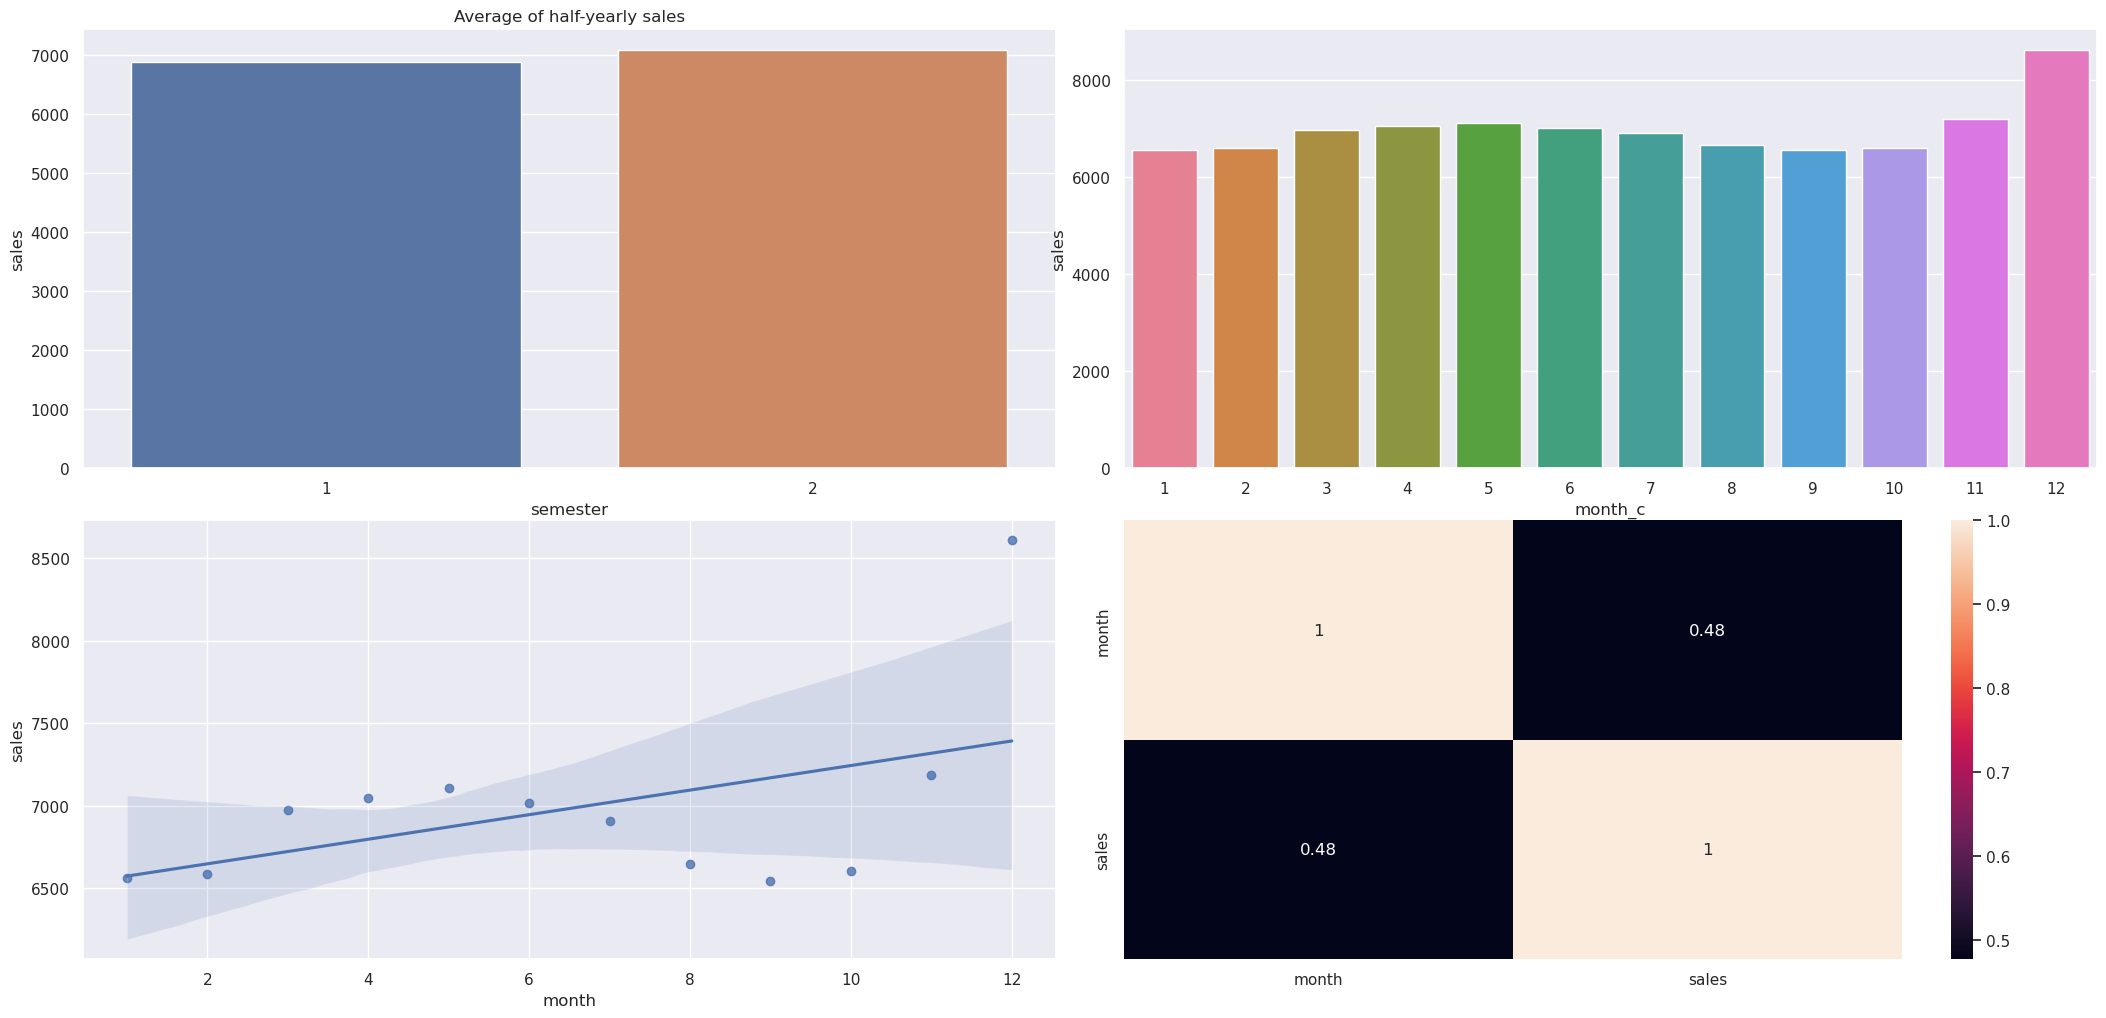

In [337]:

fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()

aux1 = X_train[['month', 'sales']].groupby('month').mean().reset_index()
avg_sales_first_sem = aux1[aux1['month'] <= 6]['sales'].mean()
avg_sales_second_sem = aux1[aux1['month'] > 6]['sales'].mean()

# Convert month to categorical
aux1['month_c'] = aux1['month'].astype('category')

df= pd.DataFrame(data= {'sales': [avg_sales_first_sem, avg_sales_second_sem], 'semester': ['1', '2']})

sns.barplot(x='semester', y='sales', hue='semester', data =df, ax=ax[0,0]).set(title='Average of half-yearly sales')

sns.barplot( x='month_c', y='sales', hue='month_c', data=aux1 , ax=ax[0,1]);
ax[0,1].legend_.remove()

sns.regplot( x='month', y='sales', data=aux1, ax=ax[1,0]);

sns.heatmap( aux1[['month', 'sales']].corr( method='pearson' ), annot=True );

#### Hypothesis Testing

- **Null Hypothesis (H0)**: The mean sales in the second half of the year are less or equal than the mean sales in the first half of the year.

- **Alternative Hypothesis (H1)**: The mean sales in the second half of the year are greater than or equal to the mean sales in the first half of the year.

In [338]:
# Divide the data
sales_first_half = X_train[X_train['month'].between(1, 6)]['sales']
sales_second_half = X_train[X_train['month'].between(7, 12)]['sales']

# Perform the one-sided t-test
t_stat, p_value = stats.ttest_ind(sales_second_half, sales_first_half, alternative='greater')

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 26.8183909751068
P-value: 1.1588136068938568e-158


- **P-value < 0.05**: There is statistical evidence to reject the null hypothesis. This means that there is enough evidence to conclude that sales in the second half of the year are greater than sales in the first half of the year.

### **H8.** Stores should sell less after the 10th of each month.

**True** there is enough evidence to conclude that sales before the 10th of the month are greater

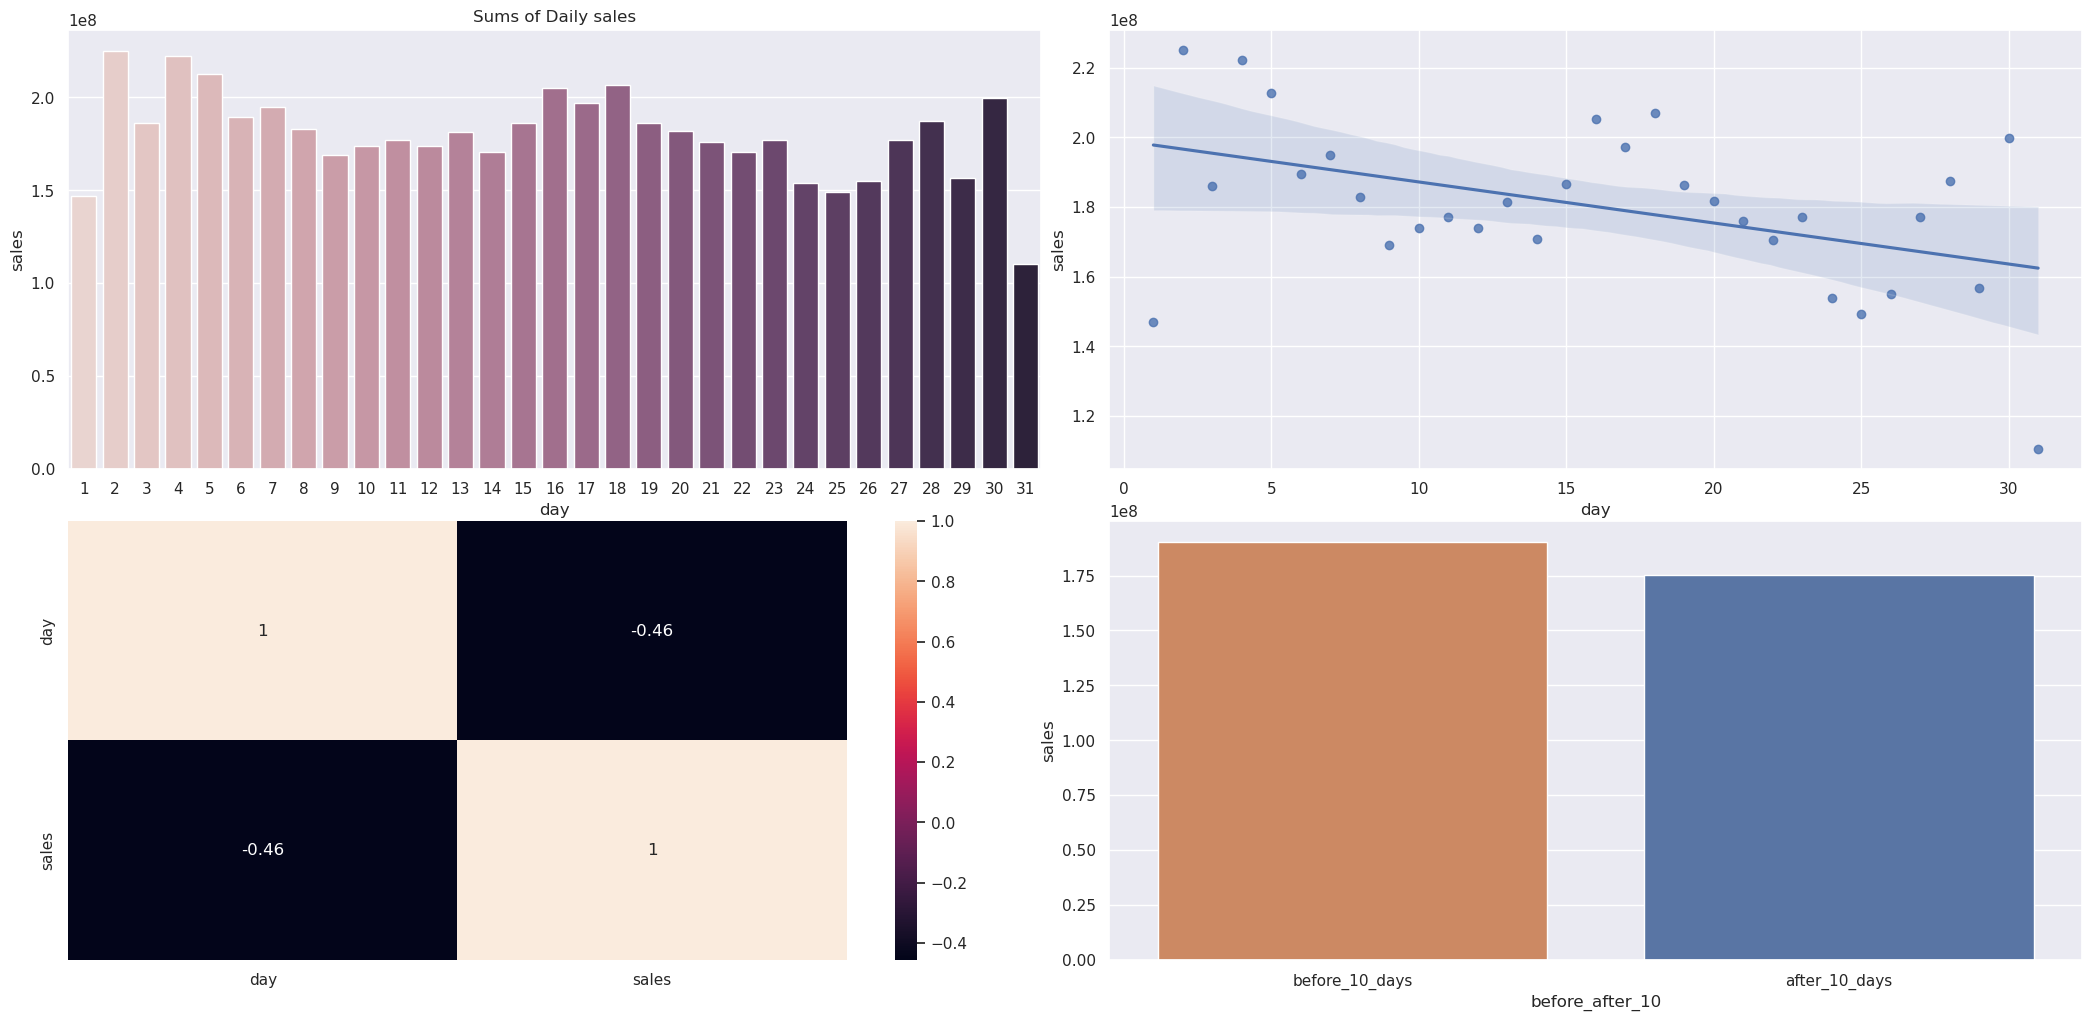

In [339]:

fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()

aux1 = X_train[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', hue='day', data=aux1, ax=ax[0,0]).set(title='Sums of Daily sales');
ax[0,0].legend_.remove()

sns.regplot(x='day', y='sales', data=aux1, ax=ax[0,1]);

sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[1,0]);

aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after_10', 'sales']].groupby( 'before_after_10' ).mean().reset_index()
sns.barplot(x='before_after_10', y='sales', hue='before_after_10', data=aux2, ax=ax[1,1], order=['before_10_days', 'after_10_days']);


#### Hypothesis Testing

- **Null Hypothesis (H0)**: Sales before the 10th of the month are less than or equal to sales after the 10th of the month.

 
- **Alternative Hypothesis (H1)**: Sales before the 10th of the month are greater than sales after the 10th of the month.

In [340]:
# Divide the data
sales_before_10 = X_train[X_train['day'] <= 10]['sales']
sales_after_10 = X_train[X_train['day'] > 10]['sales']

# Perform the one-sided t-test
t_stat, p_value = stats.ttest_ind(sales_before_10, sales_after_10, alternative='greater')

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 71.48044319386152
P-value: 0.0


- **P-value < 0.05**: There is statistical evidence to reject the null hypothesis. This means that there is enough evidence to conclude that sales before the 10th of the month are greater than sales after the 10th of the month.

### **H9.** Stores should sell more on average on weekends.

**False**, there is not enough evidence to conclude that sales on weekends are greater than sales on weekdays.

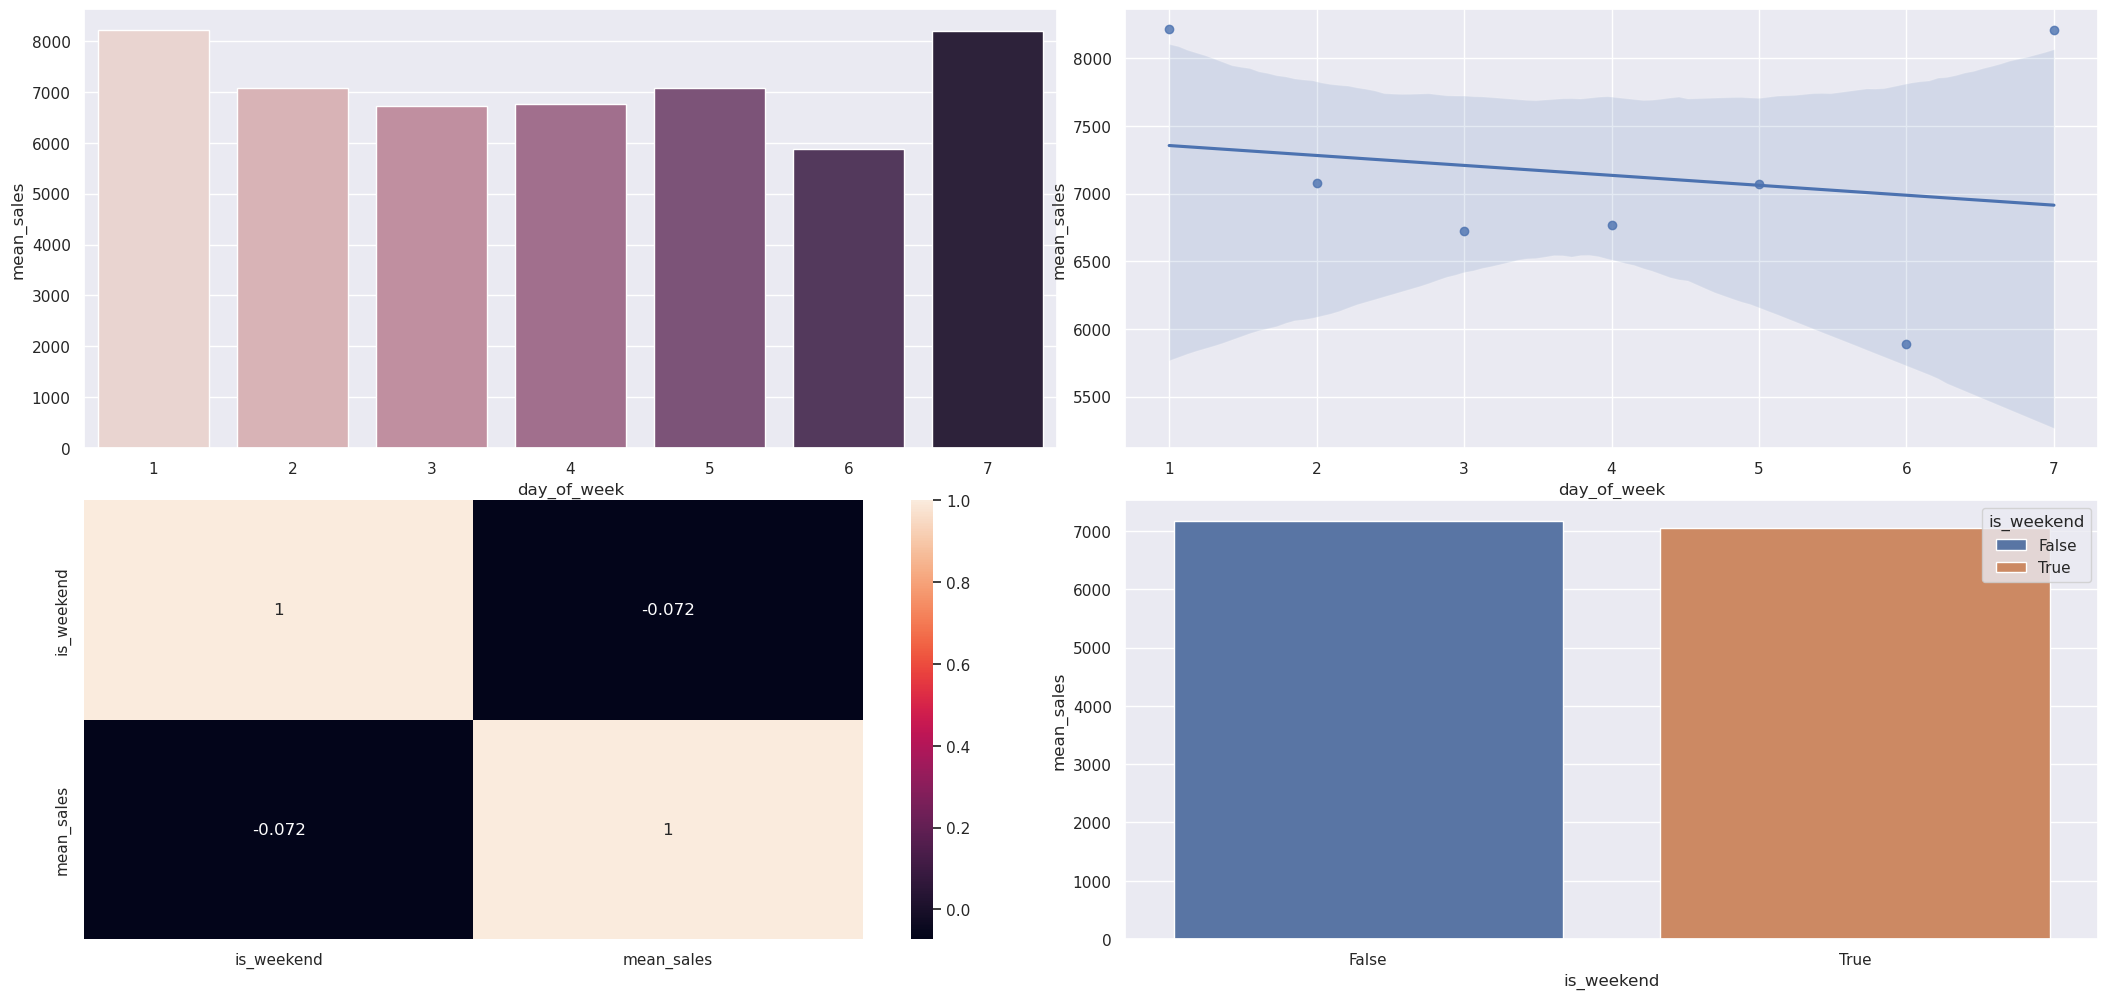

In [341]:
fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()

aux1 = X_train[['day_of_week', 'sales']].groupby('day_of_week').mean().rename(columns={'sales': 'mean_sales'}).reset_index()
sns.barplot(x='day_of_week', y='mean_sales', hue='day_of_week', data=aux1, ax=ax[0,0]);
ax[0,0].legend_.remove()

sns.regplot(x='day_of_week', y='mean_sales', data=aux1, ax=ax[0,1]);

aux1['is_weekend'] = aux1['day_of_week'].apply(lambda x: True if x >= 6 else False)

sns.heatmap(aux1[['is_weekend', 'mean_sales']].corr(method='pearson'), annot=True, ax=ax[1,0]);

sns.barplot()


aux2 = aux1[['is_weekend', 'mean_sales']].groupby( 'is_weekend' ).mean().reset_index()
sns.barplot(x='is_weekend', y='mean_sales', hue='is_weekend', data=aux2, ax=ax[1,1]);



#### Hypothesis Testing

- **Null Hypothesis (H0)**: Sales on weekends are less than or equal to sales on weekdays.

- **Alternative Hypothesis (H1)**: Sales on weekends are greater than to sales on weekdays.

In [342]:
# Divide the data
sales_weekends = X_train[X_train['day_of_week'] >= 6 ]['sales']
sales_weekdays = X_train[X_train['day_of_week'] > 6]['sales']

# Perform the one-sided t-test
t_stat, p_value = stats.ttest_ind(sales_weekends, sales_weekdays, alternative='greater')

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: -41.789459766589395
P-value: 1.0


- **P-value > 0.05**: There is statistical evidence to not reject the null hypothesis. This means that there is not enough evidence to conclude that sales on weekends are greater than sales on weekdays.


### **H10.** Stores should sell less during school holidays.

**False**, there is not enough evidence to conclude that sales on school holidays are greater than sales on regular days.

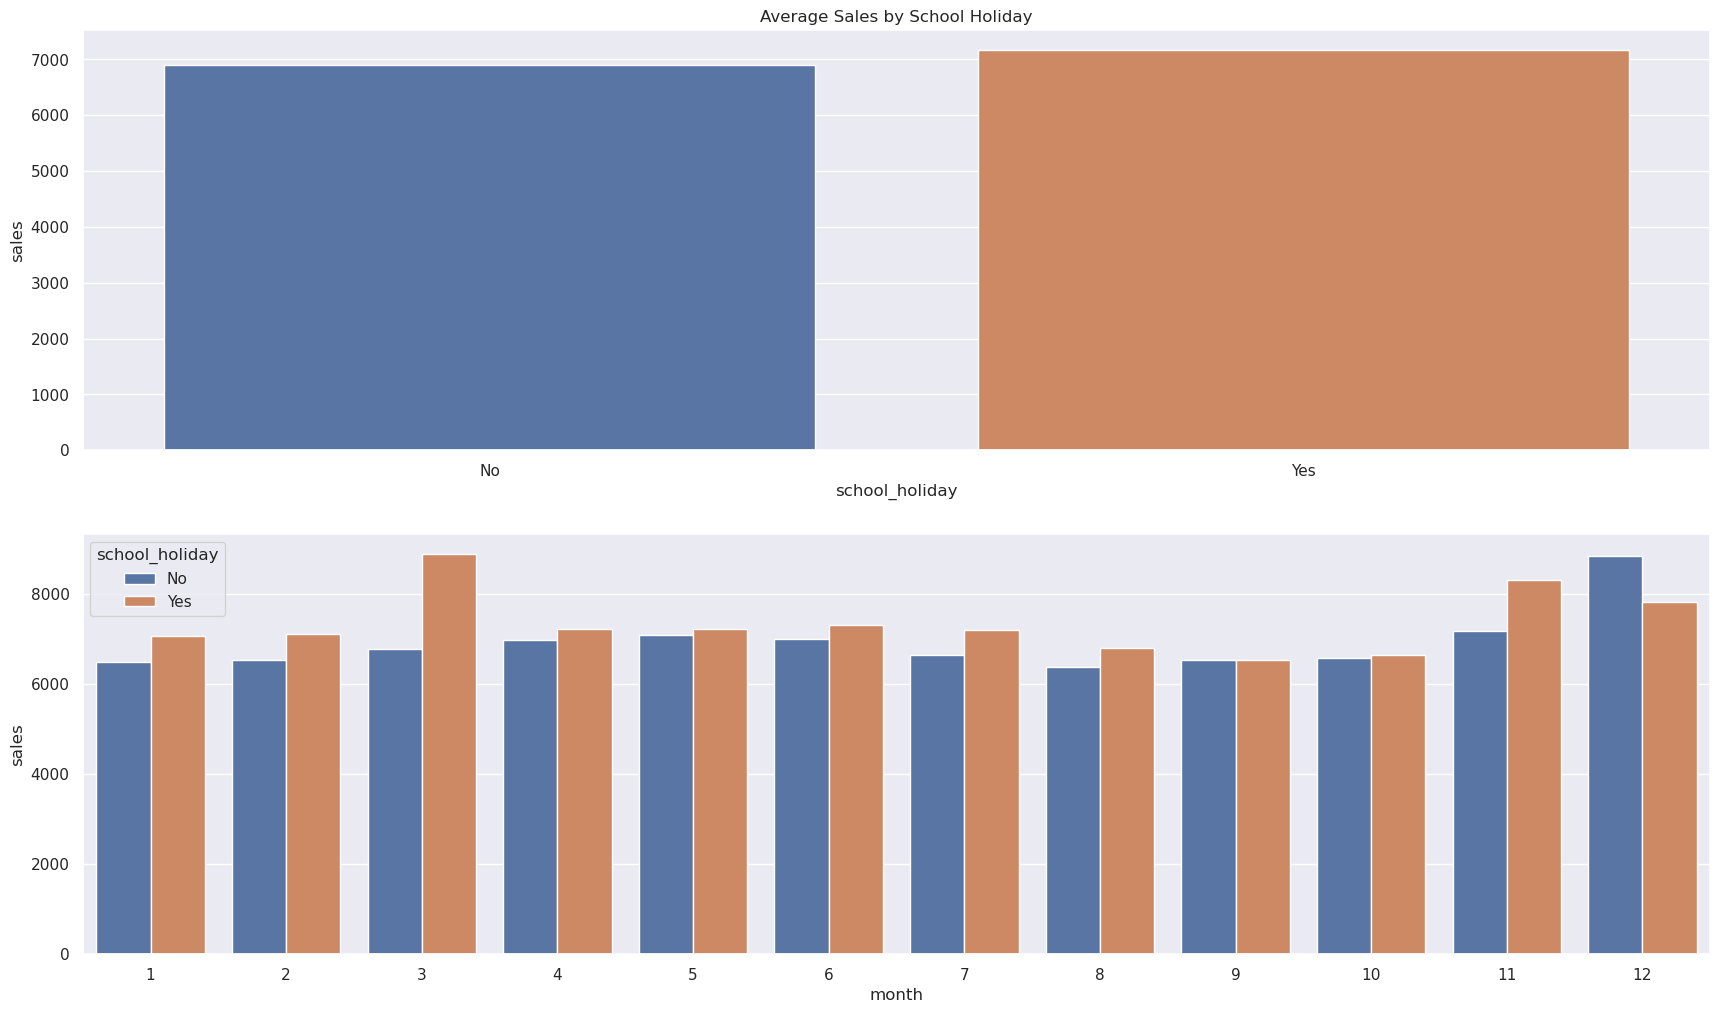

In [343]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=1, nrows=2, figure = fig)

ax1 = fig.add_subplot(specs[0])
ax2 = fig.add_subplot(specs[1])

aux1 = X_train[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
aux1['school_holiday'] = aux1['school_holiday'].map({0: 'No', 1: 'Yes'})

sns.barplot(x='school_holiday', y='sales', data=aux1, hue='school_holiday', ax=ax1).set(title='Average Sales by School Holiday')

aux2 = X_train[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
aux2['school_holiday'] = aux2['school_holiday'].map({0: 'No', 1: 'Yes'})
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 , ax=ax2);

fig.savefig('./img/H11.png')

#### Hypothesis Testing

- **Null Hypothesis (H0)**: Sales on school holidays are greater than or equal to sales on days without school holidays.

- **Alternative Hypothesis (H1)**: Sales on school holidays are less than to sales on days without school holidays.

In [344]:
# Divide the data
sales_w_sh = X_train[X_train['school_holiday'] == 1]['sales']
sales_wo_sh = X_train[X_train['school_holiday'] == 0 ]['sales']

# Perform the one-sided t-test
t_stat, p_value = stats.ttest_ind(sales_w_sh, sales_wo_sh, alternative='less')

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 29.20637654671522
P-value: 1.0


- **P-value > 0.05**: There is statistical evidence to not reject the null hypothesis. This means that there is not enough evidence to conclude that sales on school holiday are less than sales on days without school holiday.

## <span style="color: orange;">6.2.1</span> Summary of Hypotheses

In [345]:

tab =[['Hypotheses', 'Conclusion', 'Relevance'],
      ['H1', 'True', 'High'],  
      ['H2', 'False', 'Low'],  
      ['H3', 'False', 'Low'],
      ['H4', 'False', 'High'],
      ['H5', 'True', 'High'],
      ['H6', 'True', 'Low'],
      ['H7', 'True', 'High'],
      ['H8', 'True', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'False', 'High']
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            False         Low
H3            False         Low
H4            False         High
H5            True          High
H6            True          Low
H7            True          High
H8            True          High
H9            False         High
H10           False         High


## <span style="color: orange;">6.3.</span> Multivariate Analysis

### <span style="color: orange;"> 6.3.1</span> Numerical Attributes

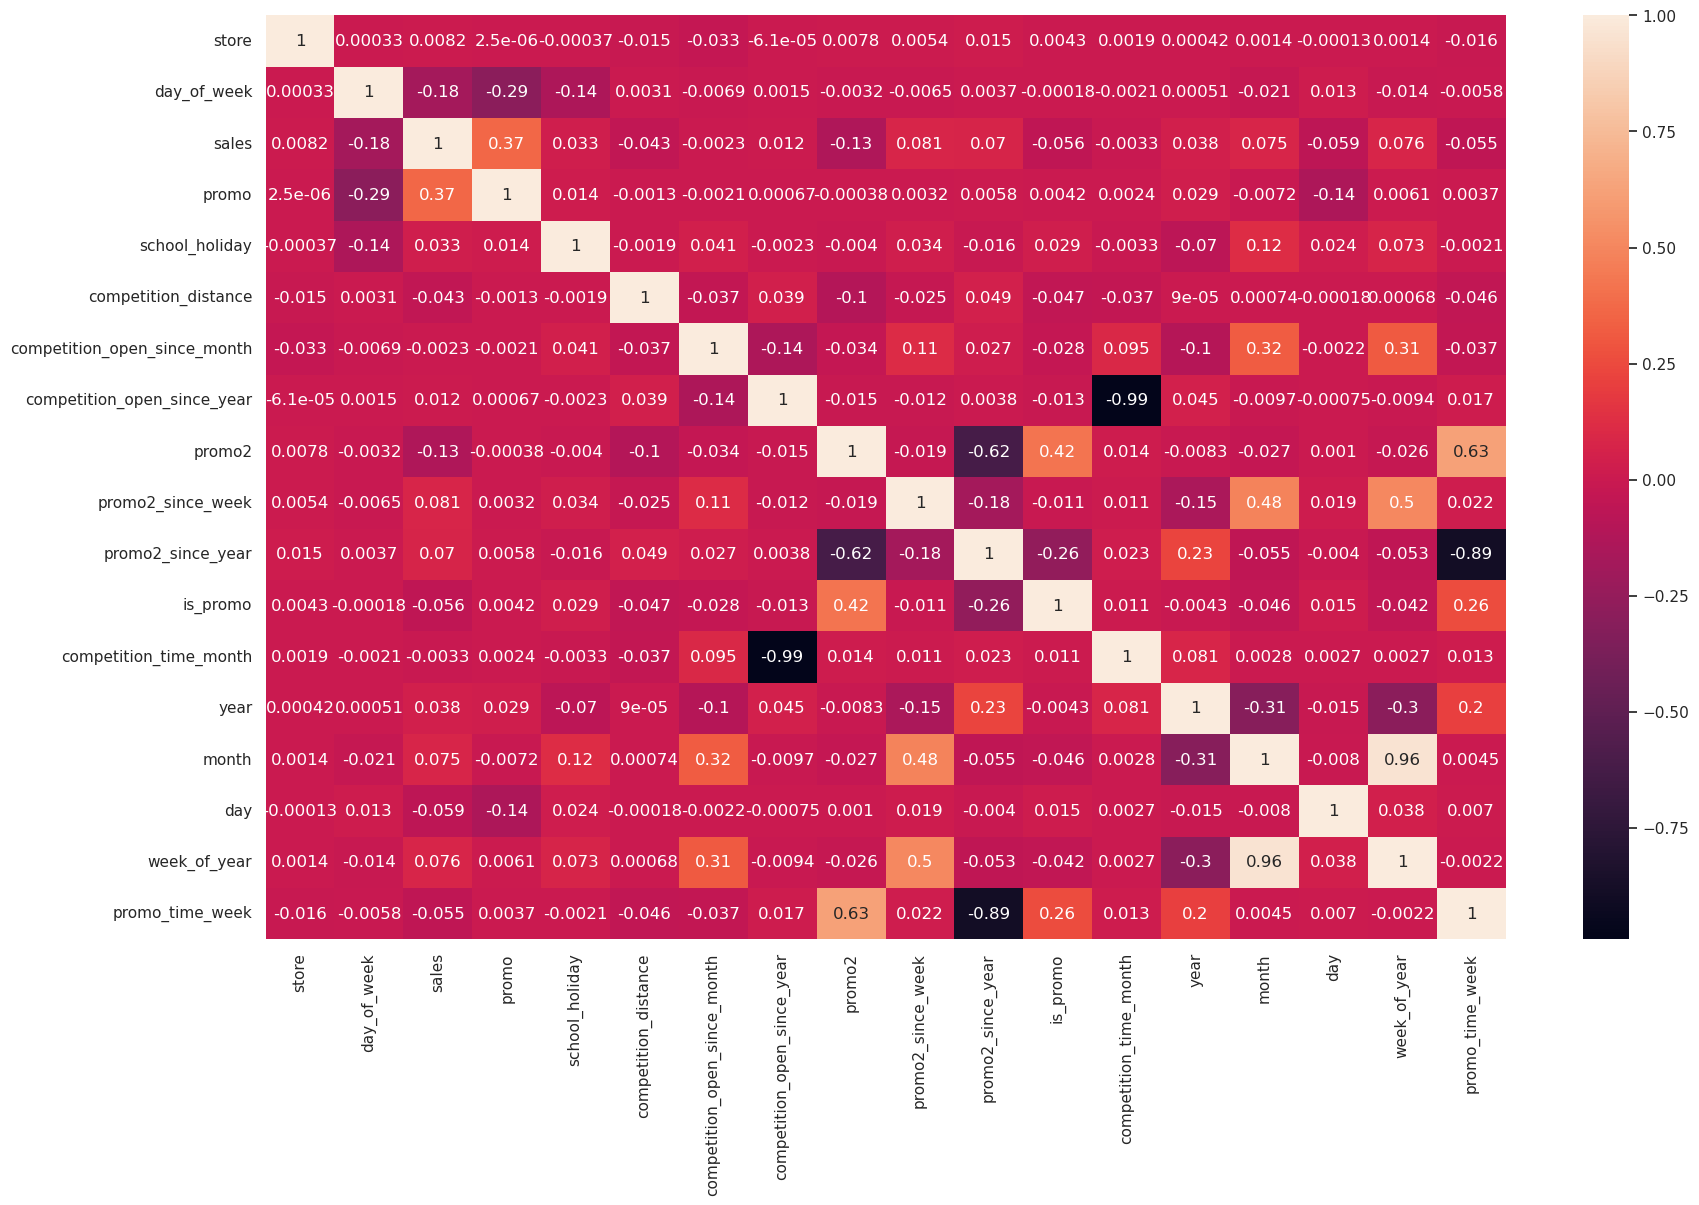

In [346]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()
 
# plotting a triangle correlation heatmap
sns.heatmap(num_attributes.corr(method='pearson'), annot=True, ax=ax);

### <span style="color: orange;"> 6.3.2</span> Categorical Attributes

In [273]:
cat_attributes = X_train.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']);

# removing 'year_week' because is date
cat_attributes.drop('year_week', axis=1, inplace=True)

print(cat_attributes.columns)

Index(['state_holiday', 'store_type', 'assortment'], dtype='object')


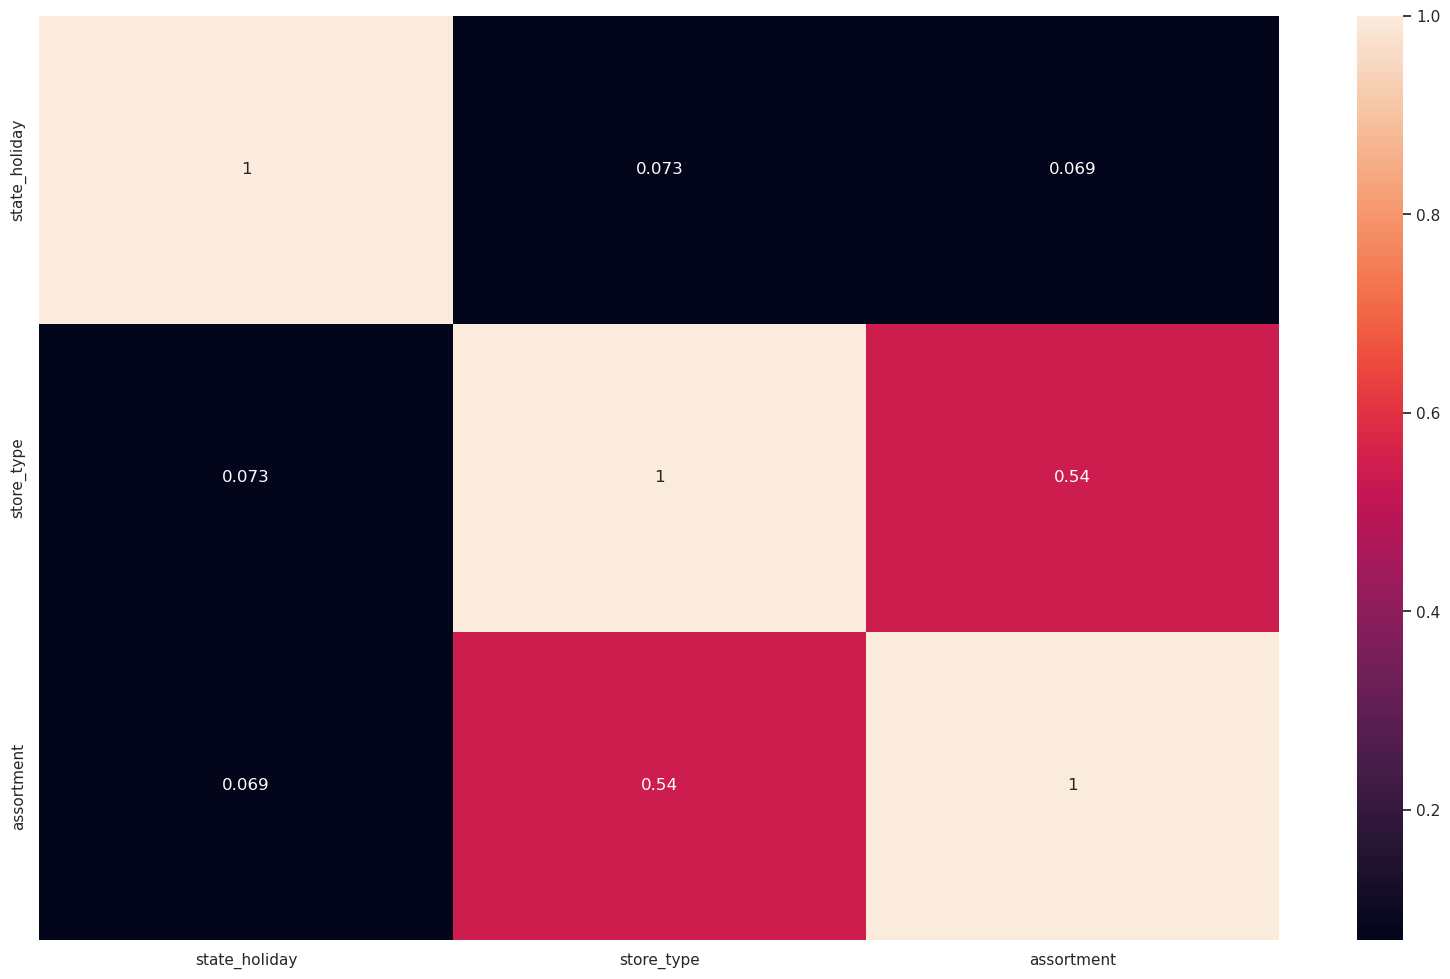

In [315]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()

# Initialize an empty DataFrame for the results
results = pd.DataFrame(index=cat_attributes.columns, columns=cat_attributes.columns, dtype=float)

# Loop through the combinations of columns to calculate Cramér V
for col1 in cat_attributes.columns:
    for col2 in cat_attributes.columns:
        results.loc[col1, col2] = cramer_v(cat_attributes[col1], cat_attributes[col2])

# Plot heatmap
sns.heatmap(results, annot=True, ax=ax)
plt.show()

# <span style="color: orange;">7.0.</span> Data Preparation

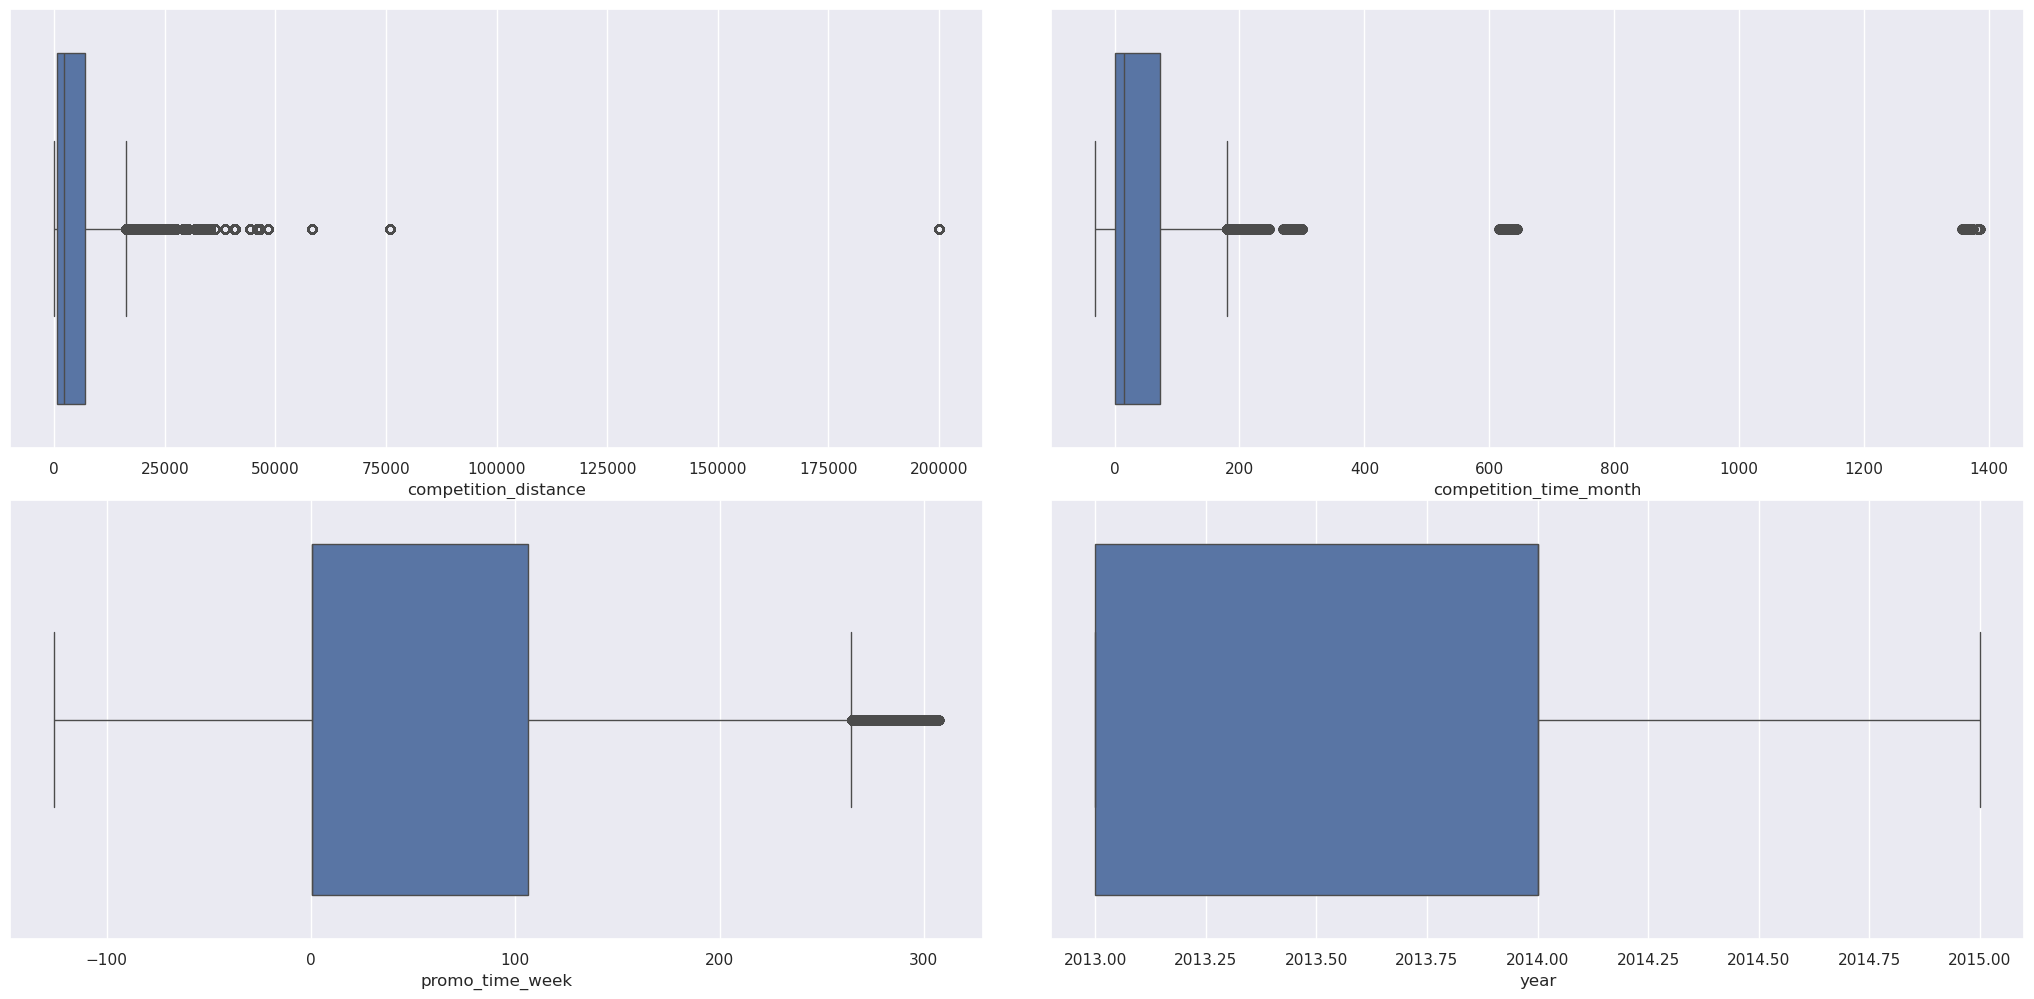

In [348]:
fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()

sns.boxplot(x=X_train['competition_distance'], ax=ax[0,0])
sns.boxplot(x=X_train['competition_time_month'], ax=ax[0,1])
sns.boxplot(x=X_train['promo_time_week'], ax=ax[1,0])
sns.boxplot(x=X_train['year'], ax=ax[1,1]);

In [365]:
X_train = pd.read_csv('./dataframes/X_train.csv', parse_dates=['date', 'competition_since', 'promo_since'])
y_train = pd.read_csv('./dataframes/y_train.csv').squeeze("columns")
X_test = pd.read_csv('./dataframes/X_test.csv', parse_dates=['date', 'competition_since', 'promo_since'])
y_test = pd.read_csv('./dataframes/y_test.csv').squeeze("columns")

rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
X_train['competition_distance'] = rs.fit_transform(X_train[['competition_distance']])
X_test['competition_distance'] = rs.transform(X_test['competition_distance'])

# competition_time_month
X_train['competition_time_month'] = rs.fit_transform(X_train['competition_time_month'])
X_test['competition_time_month'] = rs.transform(X_test['competition_time_month'])

# promo_time_week
X_train['promo_time_week'] = mms.fit_transform(X_train['promo_time_week'])
X_test['promo_time_week'] = mms.transform(X_test['promo_time_week'])

# year
X_train['year'] = mms.fit_transform(X_train['year'])
X_test['year'] = mms.transform(X_test['year'])

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.